<a href="https://colab.research.google.com/github/falahamro/Identity_mapping/blob/main/Final_Holistic_Identity_Mapping_domestic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Characterizing Recurrent Communication Patterns of Domestic Radical Extremists (DVEs) Behavior**

The aim of this work is to study users' information dissemination behavior on twitter. Of particular interest to us has been studying information sharing traits and patterns of DVEs on social media, users, type of users, and the motivations that drive their behaviors. Therefore, we seek to identify user behavioral attributes in reactions to content sharing related to societal crisis events via unsupervised and supervised learning. Our research questions for the first phase are:

1. How can we model user identity based on interaction behavior in social media?
2. How does user identify evolve across time in the context of specific events (e.g., extremism events)?
3. What are the factors associated with the change in user identity and can we predict them?


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jun 17 17:41:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import *
import matplotlib.ticker as ticker
from pandas.plotting import parallel_coordinates
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.cluster import KMeans, SpectralClustering
from plotly.colors import n_colors
import plotly.express as px
from sklearn import preprocessing
from seaborn import palettes
import re
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import sklearn
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import datetime
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To select an appropriate context for our study, we leveraged the Gdelt project to identify most active social movements in the years 2020 and 2021 by running our query on google big query available at (provide screenshot of the query output). From the preliminary analysis of the events, we identify the attack on the U.S Capitol January 6, 2021, as our context. Subsequently, we extracted twitter data using the Twitter Academic API (Twitter API for Academic Research Product Track, 2021). We restricted our dataset to focus on the timeline two weeks prior and two weeks post January 6, 2021. Table provides a summary of the dataset.

You can find our code for the query here: 

https://github.com/falahamro/twitter_harvest_academic/blob/main/Twitter_Query.ipynb

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Clustering_Kmeans/Holistic Identity Mapping.csv")

In [ ]:
df[["author_id"]] = df[["author_id"]].astype(str) 
df

,author_id,followers_count,following_count,listed_count,tweet_count,text,created_at,retweet_count,reply_count,like_count,quote_count
0,9.03752e+17,1771,3576,8,45328,@ofpeopl @agargmd Many people know the stopthe...,2021-01-28 23:59:15+00:00,0,0,0,0
1,2518375567.0,4,37,0,421,I'd say I'm shocked by just how naive/ignorant...,2021-01-28 23:55:00+00:00,0,0,0,0
2,17240656.0,394,954,0,23278,And then there is Dave LaRock -- to be fair --...,2021-01-28 23:54:51+00:00,2,1,3,0
3,19004536.0,289,471,2,34442,@govkristinoem Yes. Joe #NotMyPresident and he...,2021-01-28 23:52:46+00:00,0,0,1,0
4,1.25097e+18,1727,2557,3,18984,@SenatorRomney We could've worked to #StopTheS...,2021-01-28 23:52:41+00:00,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
66441,2996813564.0,7,29,1,113,@SenTedCruz You are our last hope... Do what y...,2020-12-20 00:06:56+00:00,0,0,0,0
66442,171243230.0,106,440,1,6148,"@jaketapper No judge has laughed, and she will...",2020-12-20 00:04:58+00:00,0,0,0,0
66443,7.65979e+17,6129,1000,10,24696,True.\n\nBUT!!...\n\nEvery day YOU don’t fight...,2020-12-20 00:02:55+00:00,0,0,0,0
66444,2945379116.0,4139,4997,0,97757,#DoNotRatifyFraud!⚖️#StopTheSteal!\n*Demand Yo...,2020-12-20 00:02:07+00:00,0,0,0,0


User Meta Data
    To identify the discriminative patterns of user behavior, the following user features metadata is collected : 
1. Following count – The number of users a user is following, to inform the user’s interest-driven participation.

2. Followers count – The number of followers a user has, to inform the user’s influence.

3. Sociability (calculation of this feature score is theory driven) – Ratio of number of Friends to Followers of a user, to inform the user’s social structure. Sociability = log(1+ 1+ f riends_count 1+ f ollowers_count)

4. Influence Score ( (calculation of this feature score is theory driven) – the social reputation of each user based on follower and following counts and is computed by log ((1 + followers count) 2 + log(statuses count) − log(friends count)).

5. Statuses count – The number of historic tweets of a user to inform a general degree of participation on the platform.

6. Favorites count – The number of tweets a user has favorited over time to inform a higher engagement level on the platform.

7. Listed count – The number of public lists subscribing a user, to inform user’s expertise.

8. Hashtag count – the total number of hashtags a user had used across all tweets.

9. Favorability ( (calculation of this feature score is theory driven))– Ratio of the number of favorites to the total number of tweets, to inform higher engagement in contrast to just posting tweets. 

10. Favorability ( (calculation of this feature score is theory driven))= log(1+ 1+ f avorites_count 1+tweet_count )

11. Survivability – Number of days since account creation, to inform the potential active existence on the platform over time. Survivability = log(1+no._o f _days)

12. Activeness – Ratio of number of tweet statuses to the number of days since account creation, to inform likelihood of a user to be active on a day on average. Activeness = log(1+ 1+status_count 1+no._o f _days )


To incorporate temporal analysis, we need to follow user behavior prior to the event, during event, and post event. Therefore we start off by fixing the temporal aspects of the data and create cohort groups throughout the timeframe we choose. 

In [ ]:
df.created_at  = pd.to_datetime(df.created_at)
df.created_at = df.created_at.apply(lambda x: x.strftime('%Y-%m-%d'))
df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True)
df['created_at_month'] = df['created_at'].dt.strftime('%Y-%m-%d')
df['dayOfWeek'] = df['created_at'].dt.day_name()

In [ ]:
#Adding month created column and append to original
cohorts = df.groupby('author_id',as_index=False)['created_at_month'].min()
cohorts.rename(columns = {'created_at_month':'cohort'},inplace=True)
df_merged = pd.merge(df, cohorts, how='left', on='author_id')
#df_merged

In [ ]:
def next_weekday(d):
    '''
    Convert Order Date to a Order Group, Represented by Year-Month-Date Format where
    Date is the same date if the input date is monday 
    else the date is next monday date of provided date.
    '''
    day_of_week = d.weekday()
    if day_of_week !=0:
        d = d + datetime.timedelta(7 - day_of_week)
        
    return d.strftime('%Y-%m-%d')

#Grouping users who posted their first tweet in same week
df_merged.set_index('author_id', inplace=True)

df_merged['RootCohortGroup'] = df_merged.groupby(level =0)['created_at'].min().apply(next_weekday)
#df_merged

In [ ]:
df_merged.reset_index(inplace=True)

In [ ]:
df_merged['WeeklyPostingPeriod'] = df_merged.created_at.apply(next_weekday)
df_merged.head(3)

,author_id,followers_count,following_count,listed_count,tweet_count,text,created_at,retweet_count,reply_count,like_count,quote_count,created_at_month,dayOfWeek,cohort,RootCohortGroup,WeeklyPostingPeriod
0,9.03752e+17,1771,3576,8,45328,@ofpeopl @agargmd Many people know the stopthe...,2021-01-28,0,0,0,0,2021-01-28,Thursday,2021-01-28,2021-02-01,2021-02-01
1,2518375567.0,4,37,0,421,I'd say I'm shocked by just how naive/ignorant...,2021-01-28,0,0,0,0,2021-01-28,Thursday,2021-01-28,2021-02-01,2021-02-01
2,17240656.0,394,954,0,23278,And then there is Dave LaRock -- to be fair --...,2021-01-28,2,1,3,0,2021-01-28,Thursday,2021-01-28,2021-02-01,2021-02-01


In our dataframe above we now have two additional columns reflecting different dates that we can later incorporate in the analysis. 

In [ ]:
df_merged["RootCohortGroup"].nunique() # this group as 7 dates we can review. Within each of those dates, we can study the user behavior in that group. 

7

Grouping data by RootCohortGroup then by WeeklyPostingPeriod and count unique counts

In [ ]:
grouped = df_merged.groupby(['RootCohortGroup', 'WeeklyPostingPeriod']).agg({'author_id': pd.Series.nunique})
grouped

author_id
RootCohortGroup WeeklyPostingPeriod           
2020-12-21      2020-12-21                1975
                2020-12-28                 758
                2021-01-04                 839
                2021-01-11                 684
                2021-01-18                 158
                2021-01-25                  94
                2021-02-01                  27
2020-12-28      2020-12-28                3324
                2021-01-04                1047
                2021-01-11                 878
                2021-01-18                 196
                2021-01-25                  90
                2021-02-01                  30
2021-01-04      2021-01-04                5472
                2021-01-11                1239
                2021-01-18                 234
                2021-01-25                 106
                2021-02-01                  21
2021-01-11      2021-01-11                7219
                2021-01-18                 408
                2021-01-25                 165
                2021-02-01                  56
2021-01-18      2021-01-18                3354
                2021-01-25                 108
                2021-02-01                  38
2021-01-25      2021-01-25                 955
                2021-02-01                  24
2021-02-01      2021-02-01                 403

Then we create a cohort perdiod. 

In [ ]:
def cohort_period(df):
    '''
    Takes a dataframe 
    sort dataframe by sub -group 
    creates a new column with index (for future purpose)
    '''
    df['CohortPeriod'] = np.arange(len(df))
    return df

Looking at the author_id next, we can get an idea of which users who were active in the timeframe we selected. 

In [ ]:
active = grouped.groupby(level=0).apply(cohort_period)
active

author_id  CohortPeriod
RootCohortGroup WeeklyPostingPeriod                         
2020-12-21      2020-12-21                1975             0
                2020-12-28                 758             1
                2021-01-04                 839             2
                2021-01-11                 684             3
                2021-01-18                 158             4
                2021-01-25                  94             5
                2021-02-01                  27             6
2020-12-28      2020-12-28                3324             0
                2021-01-04                1047             1
                2021-01-11                 878             2
                2021-01-18                 196             3
                2021-01-25                  90             4
                2021-02-01                  30             5
2021-01-04      2021-01-04                5472             0
                2021-01-11                1239             1
                2021-01-18                 234             2
                2021-01-25                 106             3
                2021-02-01                  21             4
2021-01-11      2021-01-11                7219             0
                2021-01-18                 408             1
                2021-01-25                 165             2
                2021-02-01                  56             3
2021-01-18      2021-01-18                3354             0
                2021-01-25                 108             1
                2021-02-01                  38             2
2021-01-25      2021-01-25                 955             0
                2021-02-01                  24             1
2021-02-01      2021-02-01                 403             0

In [ ]:
active.reset_index(inplace=True)
active.set_index(['RootCohortGroup', 'CohortPeriod'], inplace=True)
unstacked = active['author_id'].unstack(1)
unstacked.head(10)

CohortPeriod,0,1,2,3,4,5,6
RootCohortGroup,,,,,,,
2020-12-21,1975.0,758.0,839.0,684.0,158.0,94.0,27.0
2020-12-28,3324.0,1047.0,878.0,196.0,90.0,30.0,NaN
2021-01-04,5472.0,1239.0,234.0,106.0,21.0,NaN,NaN
2021-01-11,7219.0,408.0,165.0,56.0,NaN,NaN,NaN
2021-01-18,3354.0,108.0,38.0,NaN,NaN,NaN,NaN
2021-01-25,955.0,24.0,NaN,NaN,NaN,NaN,NaN
2021-02-01,403.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#We want to observe users activity for next 4 weeks for each cohort group where the first week of order is Week 0

In [ ]:
active_6 = unstacked[[i for i in range(7)]]
active_6.columns = [f'Week {i}' for i in active_6.columns]
active_6

,Week 0,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6
RootCohortGroup,,,,,,,
2020-12-21,1975.0,758.0,839.0,684.0,158.0,94.0,27.0
2020-12-28,3324.0,1047.0,878.0,196.0,90.0,30.0,NaN
2021-01-04,5472.0,1239.0,234.0,106.0,21.0,NaN,NaN
2021-01-11,7219.0,408.0,165.0,56.0,NaN,NaN,NaN
2021-01-18,3354.0,108.0,38.0,NaN,NaN,NaN,NaN
2021-01-25,955.0,24.0,NaN,NaN,NaN,NaN,NaN
2021-02-01,403.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Now for better visualization and understanding we will convert our data to percentage
active_6_per = active_6.iloc[:,1:].div(active_6['Week 0'] , axis=0)
active_6_per

,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6
RootCohortGroup,,,,,,
2020-12-21,0.383797,0.424810,0.346329,0.080000,0.047595,0.013671
2020-12-28,0.314982,0.264140,0.058965,0.027076,0.009025,NaN
2021-01-04,0.226425,0.042763,0.019371,0.003838,NaN,NaN
2021-01-11,0.056518,0.022856,0.007757,NaN,NaN,NaN
2021-01-18,0.032200,0.011330,NaN,NaN,NaN,NaN
2021-01-25,0.025131,NaN,NaN,NaN,NaN,NaN
2021-02-01,NaN,NaN,NaN,NaN,NaN,NaN


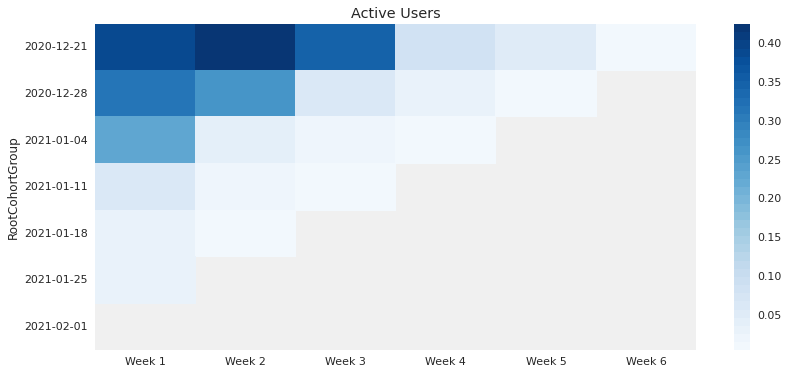

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Active Users')
heat_map = sns.heatmap(active_6_per, cmap=sns.color_palette('Blues', 40))
figure = heat_map.get_figure()    
figure.savefig('active_users.png', dpi=1000)

Observation: 
As we approach the post event date, the number of active users are dwindling. 

We'll add a variable to tell us later if the user is a repeat user or not.

In [ ]:
df_merged['REPEAT_TIME'] = df_merged.groupby('author_id').cumcount() + 1
df_merged['REPEAT_TIME'].value_counts()

1       22702
2        7351
3        4268
4        2917
5        2203
        ...  
884         1
885         1
886         1
887         1
1300        1
Name: REPEAT_TIME, Length: 1300, dtype: int64

In [ ]:
df_merged['REPEAT_USER'] = 'Y'
df_merged.loc[df_merged['REPEAT_TIME']==1, 'REPEAT_USER'] = 'N'
df_merged

,author_id,followers_count,following_count,listed_count,tweet_count,text,created_at,retweet_count,reply_count,like_count,quote_count,created_at_month,dayOfWeek,cohort,RootCohortGroup,WeeklyPostingPeriod,REPEAT_TIME,REPEAT_USER
0,9.03752e+17,1771,3576,8,45328,@ofpeopl @agargmd Many people know the stopthe...,2021-01-28,0,0,0,0,2021-01-28,Thursday,2021-01-28,2021-02-01,2021-02-01,1,N
1,2518375567.0,4,37,0,421,I'd say I'm shocked by just how naive/ignorant...,2021-01-28,0,0,0,0,2021-01-28,Thursday,2021-01-28,2021-02-01,2021-02-01,1,N
2,17240656.0,394,954,0,23278,And then there is Dave LaRock -- to be fair --...,2021-01-28,2,1,3,0,2021-01-28,Thursday,2021-01-28,2021-02-01,2021-02-01,1,N
3,19004536.0,289,471,2,34442,@govkristinoem Yes. Joe #NotMyPresident and he...,2021-01-28,0,0,1,0,2021-01-28,Thursday,2021-01-28,2021-02-01,2021-02-01,1,N
4,1.25097e+18,1727,2557,3,18984,@SenatorRomney We could've worked to #StopTheS...,2021-01-28,0,0,1,0,2021-01-28,Thursday,2020-12-20,2020-12-21,2021-02-01,1,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66441,2996813564.0,7,29,1,113,@SenTedCruz You are our last hope... Do what y...,2020-12-20,0,0,0,0,2020-12-20,Sunday,2020-12-20,2020-12-21,2020-12-21,1,N
66442,171243230.0,106,440,1,6148,"@jaketapper No judge has laughed, and she will...",2020-12-20,0,0,0,0,2020-12-20,Sunday,2020-12-20,2020-12-21,2020-12-21,7,Y
66443,7.65979e+17,6129,1000,10,24696,True.\n\nBUT!!...\n\nEvery day YOU don’t fight...,2020-12-20,0,0,0,0,2020-12-20,Sunday,2020-12-20,2020-12-21,2020-12-21,5,Y
66444,2945379116.0,4139,4997,0,97757,#DoNotRatifyFraud!⚖️#StopTheSteal!\n*Demand Yo...,2020-12-20,0,0,0,0,2020-12-20,Sunday,2020-12-20,2020-12-21,2020-12-21,214,Y


In [ ]:
active_6

,Week 0,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6
RootCohortGroup,,,,,,,
2020-12-21,1975.0,758.0,839.0,684.0,158.0,94.0,27.0
2020-12-28,3324.0,1047.0,878.0,196.0,90.0,30.0,NaN
2021-01-04,5472.0,1239.0,234.0,106.0,21.0,NaN,NaN
2021-01-11,7219.0,408.0,165.0,56.0,NaN,NaN,NaN
2021-01-18,3354.0,108.0,38.0,NaN,NaN,NaN,NaN
2021-01-25,955.0,24.0,NaN,NaN,NaN,NaN,NaN
2021-02-01,403.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# constraining our view to a cohort group posting period

gk = active_6.groupby('RootCohortGroup')
gk.get_group('2020-12-21')

,Week 0,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6
RootCohortGroup,,,,,,,
2020-12-21,1975.0,758.0,839.0,684.0,158.0,94.0,27.0


**We focus on the first cohort group then subposting periods within the cohort**

In [ ]:
df_merged['WeeklyPostingPeriod'].head()
#df_merged['RootCohortGroup'].head()

0    2021-02-01
1    2021-02-01
2    2021-02-01
3    2021-02-01
4    2021-02-01
Name: WeeklyPostingPeriod, dtype: object

Get the number of distinct users that posted in each cohort in each week

In [ ]:
df_merged['WeeklyPostingPeriod'].value_counts()
#df_merged['RootCohortGroup'].value_counts()

2021-01-11    21717
2021-01-04    19812
2020-12-28    11175
2021-01-18     6393
2020-12-21     4352
2021-01-25     2264
2021-02-01      733
Name: WeeklyPostingPeriod, dtype: int64

In [ ]:
df_merged.groupby(['WeeklyPostingPeriod'])
#df_merged.groupby(['RootCohortGroup'])

In [ ]:
RootCohortGroup_grp = df_merged.groupby(['WeeklyPostingPeriod'])
#RootCohortGroup_grp = df_merged.groupby(['RootCohortGroup'])

In [ ]:
#Change the date to the prefered weekly range needed. Values for each week are below. 
# Alternatively, we can choose to pu data from the RootCohortGroup

'''
2021-01-11    21717
2021-01-04    19812
2020-12-28    11175
2021-01-18     6393
2020-12-21     4352
2021-01-25     2264
2021-02-01      733


'''

'\n2021-01-11    21717\n2021-01-04    19812\n2020-12-28    11175\n2021-01-18     6393\n2020-12-21     4352\n2021-01-25     2264\n2021-02-01      733\n\n\n'

Let's pick 2021-01-11 cohort group and proceed to analysis

In [ ]:
constrained = RootCohortGroup_grp.get_group('2021-01-11')
#constrained = RootCohortGroup_grp.get_group('2020-12-21')

**Constrained Analysis**

In [ ]:
constrained

,author_id,followers_count,following_count,listed_count,tweet_count,text,created_at,retweet_count,reply_count,like_count,quote_count,created_at_month,dayOfWeek,cohort,RootCohortGroup,WeeklyPostingPeriod,REPEAT_TIME,REPEAT_USER
9390,210858874.0,2191,1869,94,10525,"Lawmaker, former Kalamazoo policeman tweets #s...",2021-01-11,1,0,1,0,2021-01-11,Monday,2021-01-11,2021-01-11,2021-01-11,1,N
9391,2251383210.0,3262,42,5,762093,Only one person showed up to the pro-Trump pro...,2021-01-11,0,0,0,0,2021-01-11,Monday,2021-01-03,2021-01-04,2021-01-11,1,N
9392,1.28588e+18,8,114,0,301,"@BoycottHegemony Respectfully, I tend to be al...",2021-01-11,0,0,0,0,2021-01-11,Monday,2021-01-11,2021-01-11,2021-01-11,1,N
9393,2251383210.0,3262,42,5,762093,Only one person showed up to the pro-Trump pro...,2021-01-11,0,0,0,0,2021-01-11,Monday,2021-01-03,2021-01-04,2021-01-11,2,Y
9394,7.51202e+17,46,1070,1,5264,That tells me conservative voices continue to ...,2021-01-11,0,0,0,0,2021-01-11,Monday,2021-01-11,2021-01-11,2021-01-11,1,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31102,45693003.0,1467,2518,1,24544,If GOP doesn't step up and fix this #WeThePeop...,2021-01-05,2,0,2,0,2021-01-05,Tuesday,2020-12-20,2020-12-21,2021-01-11,3,Y
31103,140298573.0,7,300,0,3678,@RepMeijer pls read &amp;share https://t.co/3c...,2021-01-05,0,0,0,0,2021-01-05,Tuesday,2021-01-04,2021-01-04,2021-01-11,9,Y
31104,75191028.0,34,75,1,4411,Millions watching &amp; praying while the Hous...,2021-01-05,0,0,0,0,2021-01-05,Tuesday,2020-12-20,2020-12-21,2021-01-11,1,N
31105,4132841.0,52491,9708,2586,99166,This is today’s immoral GOP. \n\n#trump #gop #...,2021-01-05,0,0,1,0,2021-01-05,Tuesday,2020-12-20,2020-12-21,2021-01-11,89,Y


In [ ]:
df_merged = constrained

# Calculating Theory Driven User Features/Attributes. 

In [ ]:
df_merged['folws_stat_foloing_rt']=df_merged['followers_count']**2+df_merged['following_count']-df_merged['following_count']
df_merged['Reach']=np.log(df_merged['folws_stat_foloing_rt']+1)

df_merged['followee_followers_rt']=df_merged["following_count"]+1/df_merged["followers_count"]+1
df_merged['sociability']=np.log(df_merged['followee_followers_rt']+1)

df_merged['likes_tweets_rt']=df_merged["like_count"]+1/df_merged["tweet_count"]+1
df_merged['favorabilty']=np.log(df_merged['likes_tweets_rt']+1)

# Explaratory Data Analysis (EDA)

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21717 entries, 9390 to 31106
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   author_id              21717 non-null  object        
 1   followers_count        21717 non-null  int64         
 2   following_count        21717 non-null  int64         
 3   listed_count           21717 non-null  int64         
 4   tweet_count            21717 non-null  int64         
 5   text                   21717 non-null  object        
 6   created_at             21717 non-null  datetime64[ns]
 7   retweet_count          21717 non-null  int64         
 8   reply_count            21717 non-null  int64         
 9   like_count             21717 non-null  int64         
 10  quote_count            21717 non-null  int64         
 11  created_at_month       21717 non-null  object        
 12  dayOfWeek              21717 non-null  object        
 13

In [ ]:
df_merged.isnull().sum() # # Null values in the income volumn 

author_id                0
followers_count          0
following_count          0
listed_count             0
tweet_count              0
text                     0
created_at               0
retweet_count            0
reply_count              0
like_count               0
quote_count              0
created_at_month         0
dayOfWeek                0
cohort                   0
RootCohortGroup          0
WeeklyPostingPeriod      0
REPEAT_TIME              0
REPEAT_USER              0
folws_stat_foloing_rt    0
Reach                    0
followee_followers_rt    0
sociability              0
likes_tweets_rt          0
favorabilty              0
dtype: int64

There are no missing values in our dataset. We can also visualize that from the missingno bar below. 

In [ ]:
import missingno

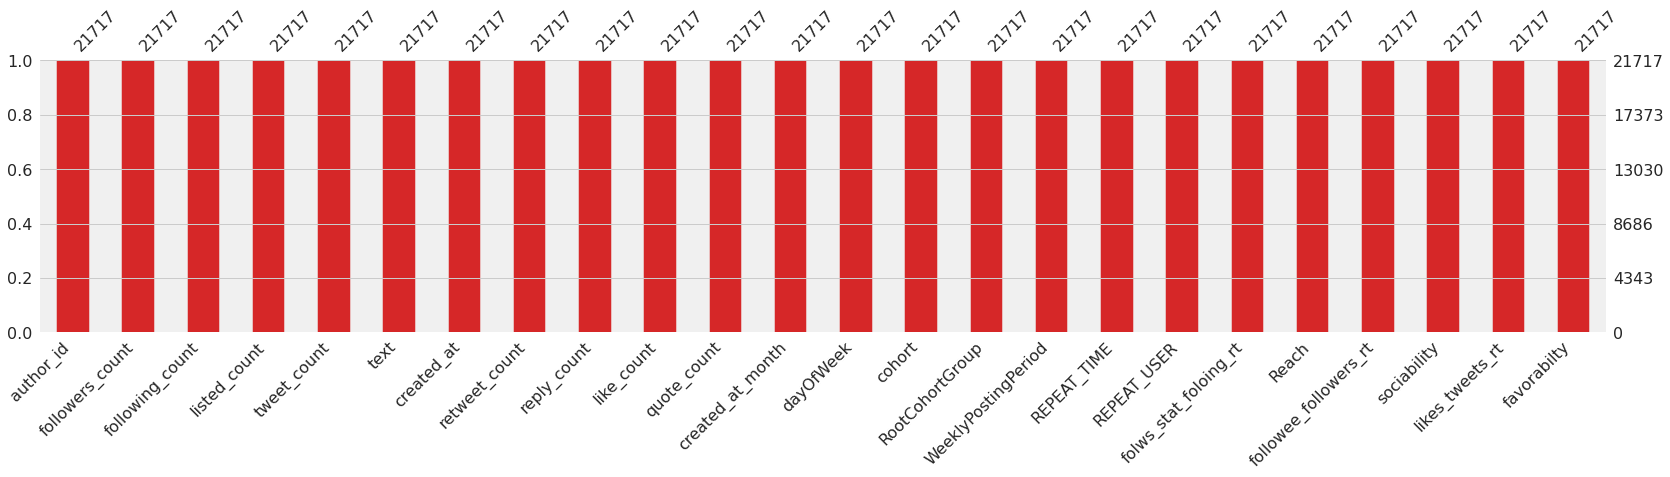

In [ ]:
missingno.bar(df_merged, figsize = (25,5), color="tab:red")

In [ ]:
# identity our categoricial features

cat_features = df_merged.select_dtypes(include=['object']).columns.tolist()
cat_features

['author_id',
 'text',
 'created_at_month',
 'dayOfWeek',
 'cohort',
 'RootCohortGroup',
 'WeeklyPostingPeriod',
 'REPEAT_USER']

In [ ]:
# identitfy numerical features 

numerical_features = df_merged.select_dtypes(exclude=['object']).columns.tolist()
numerical_features

['followers_count',
 'following_count',
 'listed_count',
 'tweet_count',
 'created_at',
 'retweet_count',
 'reply_count',
 'like_count',
 'quote_count',
 'REPEAT_TIME',
 'folws_stat_foloing_rt',
 'Reach',
 'followee_followers_rt',
 'sociability',
 'likes_tweets_rt',
 'favorabilty']

In [ ]:
# Print the count of each unique value in each column 

for column in cat_features:
  print(df_merged[column].value_counts(normalize=True))

  print("-" * 40)

278041680.0     0.011880
1.02599e+18     0.008979
27620289.0      0.006124
1.29589e+18     0.005664
80310716.0      0.005434
                  ...   
1.13389e+18     0.000046
483100920.0     0.000046
14705541.0      0.000046
1497077804.0    0.000046
75191028.0      0.000046
Name: author_id, Length: 10020, dtype: float64
----------------------------------------
@realDonaldTrump From where the American people and the entire world are sitting, there is only one person trying to STEAL the election. TRUMP. #TrumpCorruption #TrumpLiesEverytimeHeSpeaks\n#StopTheSteal\n#TraitorTrump\nhttps://t.co/i15OuX4LY9                                                                       0.000967
But @realDonaldTrump, @JoeBiden received 81,283,485 votes and secured a LANDSLIDE 306 #ElectoralCollege #Votes! #StopTheSteal                                                                                                                                                                                             

**Outliers Detection**

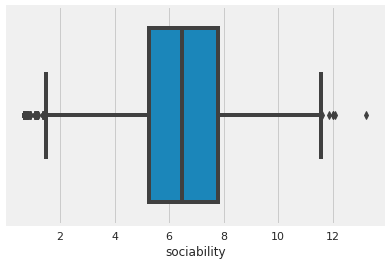

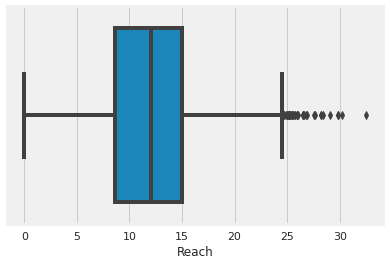

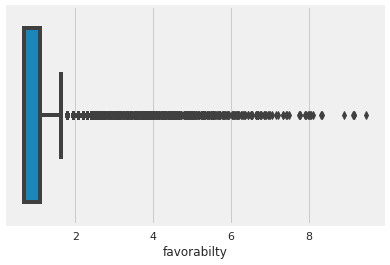

In [ ]:
# Plotting boxplot for the user features we will be using in the clustering analysis
import seaborn as sns
cols = ['sociability', 'Reach', 'favorabilty']

for i in cols:
    sns.boxplot(x = df_merged[i])
    plt.show()

In [ ]:
# Another way to find the number of users in relation to the plot agive is to use > let's see the number of obersations for which the number is more than 30 

df_merged[df_merged['Reach'] > 30]

,author_id,followers_count,following_count,listed_count,tweet_count,text,created_at,retweet_count,reply_count,like_count,...,RootCohortGroup,WeeklyPostingPeriod,REPEAT_TIME,REPEAT_USER,folws_stat_foloing_rt,Reach,followee_followers_rt,sociability,likes_tweets_rt,favorabilty
9484,16973333.0,3698965,400,26197,1250831,Peloton blocks users from creating #StopTheSte...,2021-01-11,7,1,73,...,2021-01-11,2021-01-11,1,N,13682342071225,30.247127,401.0,5.996452,74.000001,4.317488
22770,14511951.0,11370433,5595,82574,598159,The comedian pulled no punches with those atte...,2021-01-06,45,23,369,...,2021-01-11,2021-01-11,1,N,129286746607489,32.493054,5596.0,8.629986,370.000002,5.916202


Observations: 

We're going to drop the feature favoriability as dealing with outliers here is not going to make sense. We will incroprate a contenxt based feature to replace favoriability, a sentiment score. PCA and Tnse analysis will better inform us with features are more meaningful. Siluhuttee analysis will inform our clustering analysis. Both will be done later in this notebook. 

Dealing with null- if any

In [ ]:
# Filling null values with median 

df_merged['Reach'].fillna(df_merged.Reach.median(), inplace = True)

In [ ]:
#droppig na if any
df_merged = df_merged.dropna(how = 'any')
df_merged.fillna(0)
df_merged.fillna(0,inplace=True)
df_merged.fillna(0,inplace=True)
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged.replace(np.nan, 0)

,author_id,followers_count,following_count,listed_count,tweet_count,text,created_at,retweet_count,reply_count,like_count,...,RootCohortGroup,WeeklyPostingPeriod,REPEAT_TIME,REPEAT_USER,folws_stat_foloing_rt,Reach,followee_followers_rt,sociability,likes_tweets_rt,favorabilty
9390,210858874.0,2191,1869,94,10525,"Lawmaker, former Kalamazoo policeman tweets #s...",2021-01-11,1,0,1,...,2021-01-11,2021-01-11,1,N,4800481,15.384227,1870.000456,7.534229,2.000095,1.098644
9391,2251383210.0,3262,42,5,762093,Only one person showed up to the pro-Trump pro...,2021-01-11,0,0,0,...,2021-01-04,2021-01-11,1,N,10640644,16.180192,43.000307,3.784197,1.000001,0.693148
9392,1.28588e+18,8,114,0,301,"@BoycottHegemony Respectfully, I tend to be al...",2021-01-11,0,0,0,...,2021-01-11,2021-01-11,1,N,64,4.174387,115.125000,4.754667,1.003322,0.694807
9393,2251383210.0,3262,42,5,762093,Only one person showed up to the pro-Trump pro...,2021-01-11,0,0,0,...,2021-01-04,2021-01-11,2,Y,10640644,16.180192,43.000307,3.784197,1.000001,0.693148
9394,7.51202e+17,46,1070,1,5264,That tells me conservative voices continue to ...,2021-01-11,0,0,0,...,2021-01-11,2021-01-11,1,N,2116,7.657755,1071.021739,6.977302,1.000190,0.693242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31102,45693003.0,1467,2518,1,24544,If GOP doesn't step up and fix this #WeThePeop...,2021-01-05,2,0,2,...,2020-12-21,2021-01-11,3,Y,2152089,14.581950,2519.000682,7.832014,3.000041,1.386305
31103,140298573.0,7,300,0,3678,@RepMeijer pls read &amp;share https://t.co/3c...,2021-01-05,0,0,0,...,2021-01-04,2021-01-11,9,Y,49,3.912023,301.142857,5.710900,1.000272,0.693283
31104,75191028.0,34,75,1,4411,Millions watching &amp; praying while the Hous...,2021-01-05,0,0,0,...,2020-12-21,2021-01-11,1,N,1156,7.053586,76.029412,4.344187,1.000227,0.693261
31105,4132841.0,52491,9708,2586,99166,This is today’s immoral GOP. \n\n#trump #gop #...,2021-01-05,0,0,1,...,2020-12-21,2021-01-11,89,Y,2755305081,21.736794,9709.000019,9.180912,2.000010,1.098616


# Dealing with Outliers

In [ ]:
# Calculating the upper whister for the Income variable 

Q1 = df_merged.quantile(q = 0.25) # First Quartile

Q3 = df_merged.quantile(q = 0.75) # Third quartile


IQR = Q3 - Q1


upper_whisker = (Q3 + 1.5 * IQR)['Reach'] # Upper Whisker

print(upper_whisker)

24.53053197715971


In [ ]:
# Viewing the obserations makred as outliers

df_merged[df_merged.Reach > upper_whisker]

,author_id,followers_count,following_count,listed_count,tweet_count,text,created_at,retweet_count,reply_count,like_count,...,RootCohortGroup,WeeklyPostingPeriod,REPEAT_TIME,REPEAT_USER,folws_stat_foloing_rt,Reach,followee_followers_rt,sociability,likes_tweets_rt,favorabilty
9463,275686563.0,2969548,180,37752,207564,Only one person showed up to the pro-Trump pro...,2021-01-11,484,175,2720,...,2021-01-11,2021-01-11,1,N,8818215324304,29.807841,181.000000,5.204007,2721.000005,7.909122
9469,12952842.0,342350,8251,2299,221074,"Lawmaker, former Kalamazoo policeman tweets #s...",2021-01-11,7,4,5,...,2021-01-11,2021-01-11,1,N,117203522500,25.487178,8252.000003,9.018332,6.000005,1.945911
9484,16973333.0,3698965,400,26197,1250831,Peloton blocks users from creating #StopTheSte...,2021-01-11,7,1,73,...,2021-01-11,2021-01-11,1,N,13682342071225,30.247127,401.000000,5.996452,74.000001,4.317488
9554,170829095.0,282635,189,46,10621,@jennfranconews @OANN #StopTheSteal Trump is g...,2021-01-11,0,0,2,...,2021-01-11,2021-01-11,2,Y,79882543225,25.103823,190.000004,5.252273,3.000094,1.386318
9712,2483954344.0,231639,0,394,272087,Peloton blocks #StopTheSteal hashtag from bein...,2021-01-11,5,0,0,...,2021-01-11,2021-01-11,2,Y,53656626321,24.705871,1.000004,0.693149,1.000004,0.693149
9805,275686563.0,2969548,180,37752,207564,Peloton is blocking the #StopTheSteal hashtag ...,2021-01-11,23,9,220,...,2021-01-11,2021-01-11,2,Y,8818215324304,29.807841,181.000000,5.204007,221.000005,5.402677
10023,17243913.0,220137,141137,7429,119424,The masterminds of Wednesday’s #TrumpInsurrect...,2021-01-11,148,12,253,...,2021-01-11,2021-01-11,1,N,48460298769,24.604011,141138.000005,11.857500,254.000008,5.541264
10744,8.95815e+17,557181,1281,2227,2599538,"@bannerite Hello, you can read it here: #StopT...",2021-01-10,1,0,1,...,2021-01-04,2021-01-11,8,Y,310450666761,26.461291,1282.000002,7.156956,2.000000,1.098612
14218,14606079.0,939003,548,18182,95562,"More than a week ago, the founder of the #Stop...",2021-01-07,762,43,2372,...,2021-01-11,2021-01-11,1,N,881726634009,27.505148,549.000001,6.309918,2373.000010,7.772332
14581,2577886615.0,278292,1206,4621,24841,USA's days as a world supper power are over!!!...,2021-01-07,48,142,261,...,2021-01-04,2021-01-11,1,N,77446437264,25.072852,1207.000004,7.096721,262.000040,5.572154


Observations:

We have only 50 observations with an Reach greater than the upper whisker.

Let's compare the summary statistics for these observations with observations on the other side of the upper whisker.

In [ ]:
# Checking the summary statisitcs for observations makred as outliers

df_merged[df_merged.Reach > upper_whisker].describe().T

,count,mean,std,min,25%,50%,75%,max
followers_count,48.0,8.909163e+05,1.725063e+06,2.187420e+05,2.782920e+05,3.476990e+05,6.052702e+05,1.137043e+07
following_count,48.0,2.611683e+04,8.415234e+04,0.000000e+00,1.015000e+03,1.281000e+03,9.816250e+03,5.471820e+05
listed_count,48.0,8.091333e+03,1.421778e+04,4.600000e+01,1.547750e+03,2.869000e+03,4.621000e+03,8.257400e+04
tweet_count,48.0,3.698471e+05,7.131048e+05,3.066000e+03,2.484100e+04,9.359900e+04,2.862912e+05,2.599538e+06
retweet_count,48.0,3.550417e+02,1.220806e+03,0.000000e+00,6.500000e+00,2.650000e+01,1.367500e+02,7.731000e+03
reply_count,48.0,1.275208e+02,4.490376e+02,0.000000e+00,1.000000e+00,1.600000e+01,4.825000e+01,2.938000e+03
like_count,48.0,1.043771e+03,2.600616e+03,0.000000e+00,2.925000e+01,1.935000e+02,5.192500e+02,1.284200e+04
quote_count,48.0,7.779167e+01,3.430691e+02,0.000000e+00,0.000000e+00,2.000000e+00,1.425000e+01,2.325000e+03
REPEAT_TIME,48.0,2.541667e+00,2.665447e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.100000e+01
folws_stat_foloing_rt,48.0,3.707578e+12,1.869660e+13,4.784806e+10,7.744644e+10,1.208946e+11,3.671542e+11,1.292867e+14


In [ ]:
# Checking the summary statisitcs for observations not marked as outliers
df_merged[df_merged.Reach < upper_whisker].describe().T

,count,mean,std,min,25%,50%,75%,max
followers_count,21669.0,3.340946e+03,1.276035e+04,0.000000,75.000000,410.000000,1.773000e+03,2.121600e+05
following_count,21669.0,2.099435e+03,4.986391e+03,0.000000,176.000000,626.000000,2.241000e+03,1.651100e+05
listed_count,21669.0,4.716295e+01,2.237492e+02,0.000000,0.000000,3.000000,1.600000e+01,5.837000e+03
tweet_count,21669.0,3.665500e+04,8.087264e+04,1.000000,2833.000000,11732.000000,3.746700e+04,2.729429e+06
retweet_count,21669.0,1.761456e+00,3.542296e+01,0.000000,0.000000,0.000000,0.000000e+00,3.397000e+03
reply_count,21669.0,6.477456e-01,8.474321e+00,0.000000,0.000000,0.000000,0.000000e+00,7.320000e+02
like_count,21669.0,6.110665e+00,1.122393e+02,0.000000,0.000000,0.000000,1.000000e+00,9.122000e+03
quote_count,21669.0,6.917717e-01,6.807375e+01,0.000000,0.000000,0.000000,0.000000e+00,9.988000e+03
REPEAT_TIME,21669.0,1.165107e+01,2.741048e+01,1.000000,1.000000,2.000000,8.000000e+00,2.580000e+02
folws_stat_foloing_rt,21669.0,1.739808e+08,1.824369e+09,0.000000,5625.000000,168100.000000,3.143529e+06,4.501187e+10


In [ ]:
# we can drop some of the extreme outliers
#df_merged.drop(index = [527, 731, 853, 1826, 1925], inplace = True)

In [ ]:
# view selection after dropping outliers. 

#df_merged[df_merged.Reach > upper_whisker]

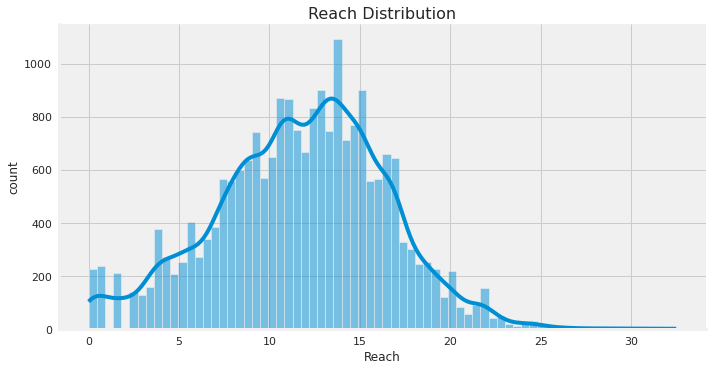

In [ ]:
# Plotting displot for income

sns.displot(df_merged['Reach'], kde = True, height = 5, aspect = 2)

plt.title('Reach Distribution', size = 16)


plt.ylabel('count');

In [ ]:
# Displaying the Co-relation between the various attributes/features
corr_map = df_merged.corr()
corr_map

,followers_count,following_count,listed_count,tweet_count,retweet_count,reply_count,like_count,quote_count,REPEAT_TIME,folws_stat_foloing_rt,Reach,followee_followers_rt,sociability,likes_tweets_rt,favorabilty
followers_count,1.000000,0.091896,0.927283,0.140749,0.125165,0.122038,0.156846,0.029116,-0.009016,0.905728,0.141589,0.091749,0.045797,0.156846,0.206144
following_count,0.091896,1.000000,0.097334,0.243692,0.017086,0.012260,0.019578,0.000979,-0.016290,0.005962,0.393897,1.000000,0.449705,0.019574,0.164991
listed_count,0.927283,0.097334,1.000000,0.152299,0.075854,0.068384,0.124038,0.017436,0.012672,0.778110,0.173142,0.097109,0.071145,0.124037,0.211058
tweet_count,0.140749,0.243692,0.152299,1.000000,0.004887,-0.000394,0.006266,-0.002062,0.057581,0.057357,0.383302,0.242608,0.259270,0.006262,0.074312
retweet_count,0.125165,0.017086,0.075854,0.004887,1.000000,0.934656,0.898885,0.542807,-0.010112,0.017211,0.081237,0.016969,0.020451,0.898885,0.307779
reply_count,0.122038,0.012260,0.068384,-0.000394,0.934656,1.000000,0.808592,0.435831,-0.010594,0.018755,0.074936,0.012148,0.018364,0.808592,0.270865
like_count,0.156846,0.019578,0.124038,0.006266,0.898885,0.808592,1.000000,0.450344,-0.013470,0.031376,0.106784,0.019422,0.027832,1.000000,0.403101
quote_count,0.029116,0.000979,0.017436,-0.002062,0.542807,0.435831,0.450344,1.000000,-0.004236,0.004079,0.019962,0.000937,0.005974,0.450344,0.122505
REPEAT_TIME,-0.009016,-0.016290,0.012672,0.057581,-0.010112,-0.010594,-0.013470,-0.004236,1.000000,-0.003562,0.029042,-0.017321,-0.051377,-0.013473,-0.057091
folws_stat_foloing_rt,0.905728,0.005962,0.778110,0.057357,0.017211,0.018755,0.031376,0.004079,-0.003562,1.000000,0.039282,0.005933,0.008587,0.031376,0.064298


In [ ]:
# Displaying the Co-variance between the various attributes/features
df_merged.cov()

,followers_count,following_count,listed_count,tweet_count,retweet_count,reply_count,like_count,quote_count,REPEAT_TIME,folws_stat_foloing_rt,Reach,followee_followers_rt,sociability,likes_tweets_rt,favorabilty
followers_count,8.340535e+09,5.400518e+07,6.722606e+07,1.140425e+09,7.880604e+05,2.598444e+05,2.463687e+06,1.859738e+05,-2.254860e+04,7.337501e+16,6.110489e+04,5.445084e+07,7.533746e+03,2.463678e+06,1.329699e+04
following_count,5.400518e+07,4.140808e+07,4.972050e+05,1.391264e+08,7.580029e+03,1.839341e+03,2.166794e+04,4.404768e+02,-2.870435e+03,3.403380e+13,1.197771e+04,4.179346e+07,5.209569e+03,2.166439e+04,7.498758e+02
listed_count,6.722606e+07,4.972050e+05,6.301692e+05,1.072631e+07,4.151328e+03,1.265626e+03,1.693546e+04,9.680530e+02,2.754695e+02,5.479270e+14,6.494993e+02,5.009447e+05,1.017275e+02,1.693535e+04,1.183361e+02
tweet_count,1.140425e+09,1.391264e+08,1.072631e+07,7.871359e+09,2.989006e+04,-8.150372e+02,9.562082e+04,-1.279763e+04,1.398934e+05,4.514056e+15,1.606991e+05,1.397495e+08,4.139659e+04,9.555675e+04,4.656595e+03
retweet_count,7.880604e+05,7.580029e+03,4.151328e+03,2.989006e+04,4.752875e+03,1.502283e+03,1.065852e+04,2.617283e+03,-1.908940e+01,1.052559e+12,2.646562e+01,7.602477e+03,2.539651e+00,1.065852e+04,1.498660e+01
reply_count,2.598444e+05,1.839341e+03,1.265626e+03,-8.150372e+02,1.502283e+03,5.435551e+02,3.242395e+03,7.106675e+02,-6.763619e+00,3.878808e+11,8.255866e+00,1.840548e+03,7.711880e-01,3.242394e+03,4.460271e+00
like_count,2.463687e+06,2.166794e+04,1.693546e+04,9.562082e+04,1.065852e+04,3.242395e+03,2.958213e+04,5.417335e+03,-6.344114e+01,4.786980e+12,8.679002e+01,2.170782e+04,8.622519e+00,2.958212e+04,4.896827e+01
quote_count,1.859738e+05,4.404768e+02,9.680530e+02,-1.279763e+04,2.617283e+03,7.106675e+02,5.417335e+03,4.891634e+03,-8.112112e+00,2.530883e+11,6.597589e+00,4.257201e+02,7.526599e-01,5.417334e+03,6.051582e+00
REPEAT_TIME,-2.254860e+04,-2.870435e+03,2.754695e+02,1.398934e+05,-1.908940e+01,-6.763619e+00,-6.344114e+01,-8.112112e+00,7.498720e+02,-8.651531e+10,3.758154e+00,-3.080501e+03,-2.532701e+00,-6.345593e+01,-1.104198e+00
folws_stat_foloing_rt,7.337501e+16,3.403380e+13,5.479270e+14,4.514056e+15,1.052559e+12,3.878808e+11,4.786980e+12,2.530883e+11,-8.651531e+10,7.868770e+23,1.646645e+11,3.420114e+13,1.372140e+10,4.786965e+12,4.028446e+10


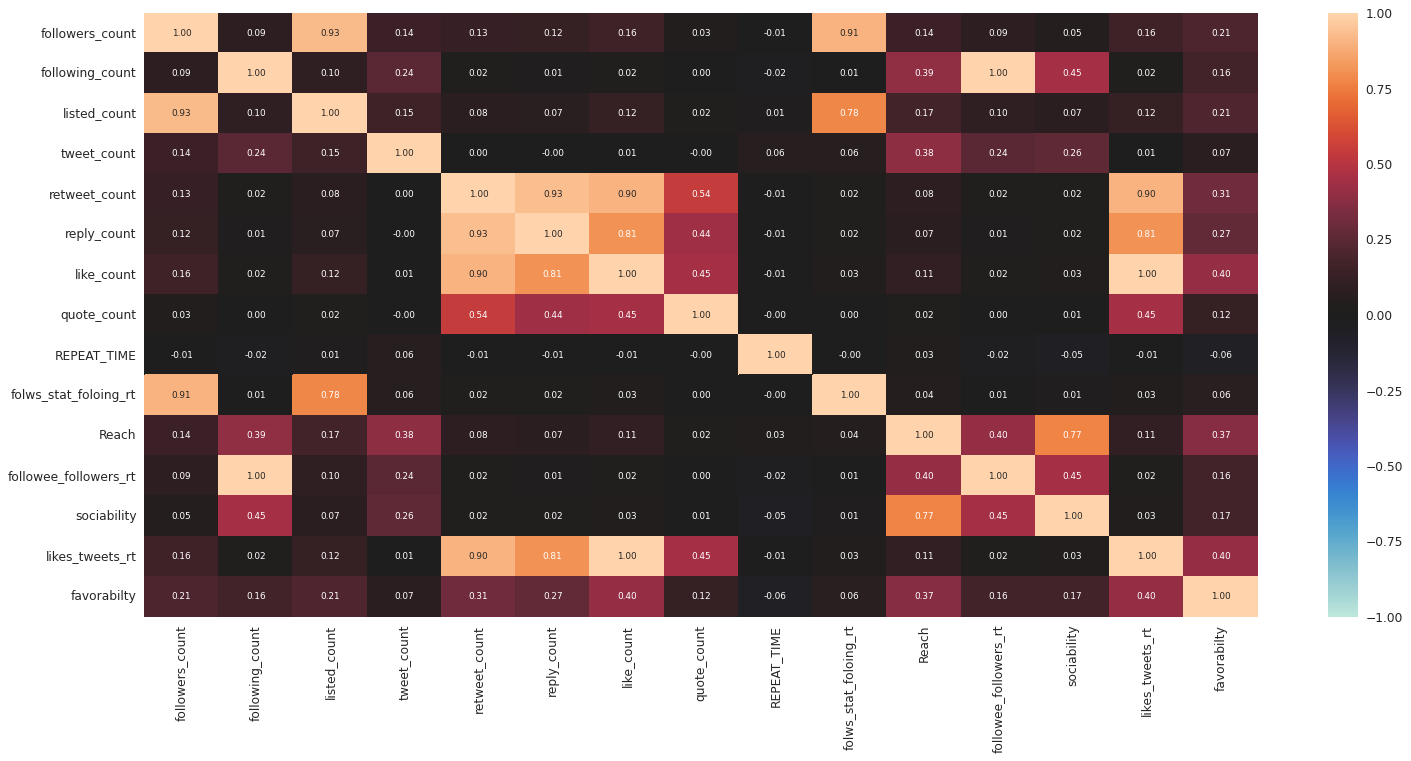

In [ ]:
# Visualising the Co-relation Heatmap between the various attributes/features
plt.figure(figsize=(20,10), dpi=80)
sns.heatmap(corr_map, vmin=-1, vmax=1, center=0, annot=True, annot_kws={'size':8}, fmt='.2f')


# Sentiment Analysis


In [ ]:
# Cleaning the tweet
def cleanText(text):
    # Removing @mentions
    text=re.sub(r'@[A-Za-z0-9]+','',text)
    
    # Removing the # symbol
    text=re.sub(r'#','',text)
    
    # Removing RT & immediate space after it, RT symbolises Retweet
    text=re.sub(r'RT[\s]+','',text)
    
    # Removing the hyperlink
    text=re.sub(r'https?:\/\/','',text)
    
    return text

df_merged['Cleaning_Tweets']=df_merged['text']

# Appyling clean function on text observed
df_merged['Cleaning_Tweets']=df_merged['Cleaning_Tweets'].apply(cleanText)


# Display cleaned text
#df_merged  

In [ ]:
# Cleaning the tweet
def cleanText(text):
    # Removing @mentions
    text=re.sub(r'@[A-Za-z0-9]+','',text)
    
    # Removing the # symbol
    text=re.sub(r'#','',text)
    
    # Removing RT & immediate space after it, RT symbolises Retweet
    text=re.sub(r'RT[\s]+','',text)
    
    # Removing the hyperlink
    text=re.sub(r'https?:\/\/','',text)
    
    return text


# Appyling clean function on text observed
df_merged['Cleaning_Tweets']=df_merged['Cleaning_Tweets'].apply(cleanText)


# Display cleaned text
#df_merged  

In [ ]:
# Create a function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get Polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity


# Creating 2 columns : Subjectivity & Polarity
df_merged['Subjectivity']=df_merged['Cleaning_Tweets'].apply(getSubjectivity)
df_merged['Polarity']=df_merged['Cleaning_Tweets'].apply(getPolarity)

# Displaying updated dataframe
#df_merged

In [ ]:
# Creating function to find tweet reflects Negative/Neutral/Positive Sentiment
def getAnalysis(score):
    if score<0:
        return 'Negative'
    elif score==0:
        return 'Neutral'
    else :
        return 'Positive'

# Apply Analysis on 'Polarity' column values
df_merged['Analysis']=df_merged['Polarity'].apply(getAnalysis)

# Display Sentiments
#df_merged

In [ ]:
sortedDF=df_merged.sort_values(by=['Polarity'])

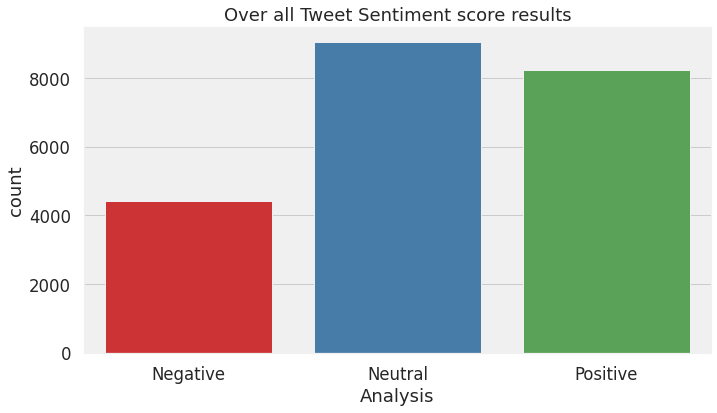

In [ ]:
plt.figure(figsize=(10,6))
sns.set_context(context='notebook',font_scale=1.5)
sns.countplot(df_merged['Analysis'],palette='Set1')
plt.title('Over all Tweet Sentiment score results');

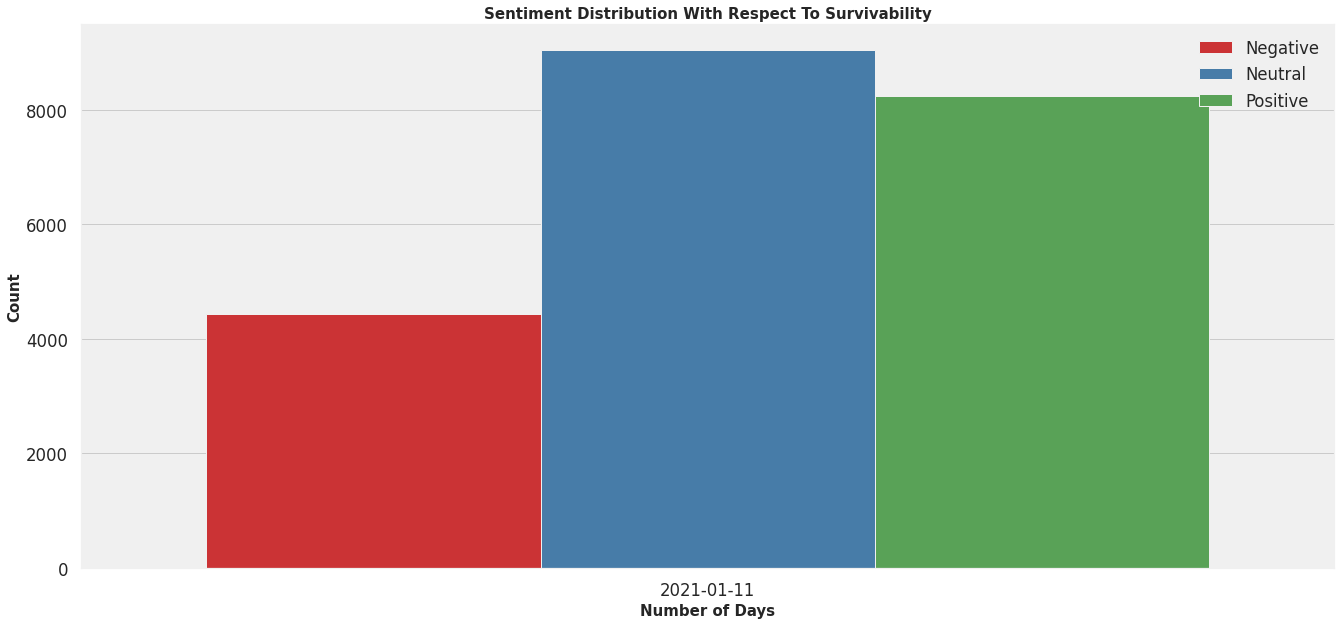

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(df_merged['WeeklyPostingPeriod'], hue=df_merged['Analysis'], palette = 'Set1')
plt.legend(loc='upper right')
plt.ylabel('Count', fontsize=15, fontweight='bold')
plt.xlabel('Number of Days', fontsize=15, fontweight='bold')
plt.title('Sentiment Distribution With Respect To Survivability', fontsize=15, fontweight='bold')
plt.show()

In [ ]:
df_merged.fillna(0,inplace=True)

In [ ]:
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df_merged['Analysis']=le.fit_transform(df_merged['Analysis'])

In [ ]:
#df_merged['Analysis'] = df_merged['Analysis'].replace(['Positive','Negative', 'Neutral'],['1','-1', '0'])

In [ ]:
df_merged.duplicated(subset=['author_id']).sum()

11697

In [ ]:
#df_merged['Analysis'] = df_merged.Analysis.astype(str).str.replace('-','-1').astype(int)
#df_merged['Analysis'] = df_merged['Analysis'].astype(int)

In [ ]:
df_merged["Analysis"].nunique()

3

In [ ]:
def pos(x):
    if x['Analysis'] == 2:
        return 2
    else:
        return 0
def neut(x):
    if x['Analysis'] == 1:
        return 1
    else:
        return 0
def neg(x):
    if x['Analysis'] == 0:
        return 0
    else:
        return 0

In [ ]:
df_merged.apply(pos, axis=1)
df_merged.apply(neut, axis=1)
df_merged.apply(neg, axis=1)

9390     0
9391     0
9392     0
9393     0
9394     0
        ..
31102    0
31103    0
31104    0
31105    0
31106    0
Length: 21717, dtype: int64

In [ ]:
df_merged['Positive'] = df_merged.apply(pos, axis=1)
df_merged['Negative'] = df_merged.apply(neut, axis=1)
df_merged['Neutral'] = df_merged.apply(neg, axis=1)

In [ ]:
df_merged

,author_id,followers_count,following_count,listed_count,tweet_count,text,created_at,retweet_count,reply_count,like_count,...,sociability,likes_tweets_rt,favorabilty,Cleaning_Tweets,Subjectivity,Polarity,Analysis,Positive,Negative,Neutral
9390,210858874.0,2191,1869,94,10525,"Lawmaker, former Kalamazoo policeman tweets #s...",2021-01-11,1,0,1,...,7.534229,2.000095,1.098644,"Lawmaker, former Kalamazoo policeman tweets st...",0.500000,-0.400000,0,0,0,0
9391,2251383210.0,3262,42,5,762093,Only one person showed up to the pro-Trump pro...,2021-01-11,0,0,0,...,3.784197,1.000001,0.693148,Only one person showed up to the pro-Trump pro...,0.525000,0.000000,1,0,1,0
9392,1.28588e+18,8,114,0,301,"@BoycottHegemony Respectfully, I tend to be al...",2021-01-11,0,0,0,...,4.754667,1.003322,0.694807,"Respectfully, I tend to be aligned with most ...",0.473526,0.250050,2,2,0,0
9393,2251383210.0,3262,42,5,762093,Only one person showed up to the pro-Trump pro...,2021-01-11,0,0,0,...,3.784197,1.000001,0.693148,Only one person showed up to the pro-Trump pro...,0.525000,0.000000,1,0,1,0
9394,7.51202e+17,46,1070,1,5264,That tells me conservative voices continue to ...,2021-01-11,0,0,0,...,6.977302,1.000190,0.693242,That tells me conservative voices continue to ...,0.325000,-0.050000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31102,45693003.0,1467,2518,1,24544,If GOP doesn't step up and fix this #WeThePeop...,2021-01-05,2,0,2,...,7.832014,3.000041,1.386305,If GOP doesn't step up and fix this WeThePeopl...,0.477273,0.168182,2,2,0,0
31103,140298573.0,7,300,0,3678,@RepMeijer pls read &amp;share https://t.co/3c...,2021-01-05,0,0,0,...,5.710900,1.000272,0.693283,pls read &amp;share t.co/3cANfMp4IF 2019 Denn...,0.000000,0.000000,1,0,1,0
31104,75191028.0,34,75,1,4411,Millions watching &amp; praying while the Hous...,2021-01-05,0,0,0,...,4.344187,1.000227,0.693261,Millions watching &amp; praying while the Hous...,1.000000,-0.800000,0,0,0,0
31105,4132841.0,52491,9708,2586,99166,This is today’s immoral GOP. \n\n#trump #gop #...,2021-01-05,0,0,1,...,9.180912,2.000010,1.098616,This is today’s immoral GOP. \n\ntrump gop mag...,0.000000,0.000000,1,0,1,0


# **Calculating new sentiment score**

In [ ]:
df_merged['total_len'] = df['text'].map(lambda x: len(x))
df_merged['Final_Sentiment'] = round((df_merged['Positive'] - df_merged['Negative']) / df_merged['total_len'], 2)

In [ ]:
#df_merged['avg_sentiment']=df_merged["Polarity"]+1/df_merged["Analysis"]+1
#df_merged['sentiment_score']=np.log(df_merged['avg_sentiment']+1)

In [ ]:
sentiment = df_merged.groupby(df['author_id'])['Analysis'].agg([('neutral' , lambda x : x[x == 0].sum()), ('negative' , lambda x : x[x == 1].sum()) , ('positive' , lambda x : x[x == 2].sum())])

In [ ]:
sentiment

,neutral,negative,positive
author_id,,,
1.00018e+18,0,0,2
1.00025e+18,0,1,0
1.00045e+18,0,3,0
1.00074e+18,0,0,8
1.00125e+18,0,1,2
...,...,...,...
99352994.0,0,2,0
993641287.0,0,0,0
99569050.0,0,1,0


In [ ]:
df_merged.set_index('author_id')

,followers_count,following_count,listed_count,tweet_count,text,created_at,retweet_count,reply_count,like_count,quote_count,...,favorabilty,Cleaning_Tweets,Subjectivity,Polarity,Analysis,Positive,Negative,Neutral,total_len,Final_Sentiment
author_id,,,,,,,,,,,,,,,,,,,,,
210858874.0,2191,1869,94,10525,"Lawmaker, former Kalamazoo policeman tweets #s...",2021-01-11,1,0,1,0,...,1.098644,"Lawmaker, former Kalamazoo policeman tweets st...",0.500000,-0.400000,0,0,0,0,115,0.00
2251383210.0,3262,42,5,762093,Only one person showed up to the pro-Trump pro...,2021-01-11,0,0,0,0,...,0.693148,Only one person showed up to the pro-Trump pro...,0.525000,0.000000,1,0,1,0,133,-0.01
1.28588e+18,8,114,0,301,"@BoycottHegemony Respectfully, I tend to be al...",2021-01-11,0,0,0,0,...,0.694807,"Respectfully, I tend to be aligned with most ...",0.473526,0.250050,2,2,0,0,221,0.01
2251383210.0,3262,42,5,762093,Only one person showed up to the pro-Trump pro...,2021-01-11,0,0,0,0,...,0.693148,Only one person showed up to the pro-Trump pro...,0.525000,0.000000,1,0,1,0,133,-0.01
7.51202e+17,46,1070,1,5264,That tells me conservative voices continue to ...,2021-01-11,0,0,0,0,...,0.693242,That tells me conservative voices continue to ...,0.325000,-0.050000,0,0,0,0,206,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45693003.0,1467,2518,1,24544,If GOP doesn't step up and fix this #WeThePeop...,2021-01-05,2,0,2,0,...,1.386305,If GOP doesn't step up and fix this WeThePeopl...,0.477273,0.168182,2,2,0,0,154,0.01
140298573.0,7,300,0,3678,@RepMeijer pls read &amp;share https://t.co/3c...,2021-01-05,0,0,0,0,...,0.693283,pls read &amp;share t.co/3cANfMp4IF 2019 Denn...,0.000000,0.000000,1,0,1,0,91,-0.01
75191028.0,34,75,1,4411,Millions watching &amp; praying while the Hous...,2021-01-05,0,0,0,0,...,0.693261,Millions watching &amp; praying while the Hous...,1.000000,-0.800000,0,0,0,0,254,0.00


In [ ]:
unaggregated = df_merged

In [ ]:
unaggregated.head()

,author_id,followers_count,following_count,listed_count,tweet_count,text,created_at,retweet_count,reply_count,like_count,...,favorabilty,Cleaning_Tweets,Subjectivity,Polarity,Analysis,Positive,Negative,Neutral,total_len,Final_Sentiment
9390,210858874.0,2191,1869,94,10525,"Lawmaker, former Kalamazoo policeman tweets #s...",2021-01-11,1,0,1,...,1.098644,"Lawmaker, former Kalamazoo policeman tweets st...",0.500000,-0.40000,0,0,0,0,115,0.00
9391,2251383210.0,3262,42,5,762093,Only one person showed up to the pro-Trump pro...,2021-01-11,0,0,0,...,0.693148,Only one person showed up to the pro-Trump pro...,0.525000,0.00000,1,0,1,0,133,-0.01
9392,1.28588e+18,8,114,0,301,"@BoycottHegemony Respectfully, I tend to be al...",2021-01-11,0,0,0,...,0.694807,"Respectfully, I tend to be aligned with most ...",0.473526,0.25005,2,2,0,0,221,0.01
9393,2251383210.0,3262,42,5,762093,Only one person showed up to the pro-Trump pro...,2021-01-11,0,0,0,...,0.693148,Only one person showed up to the pro-Trump pro...,0.525000,0.00000,1,0,1,0,133,-0.01
9394,7.51202e+17,46,1070,1,5264,That tells me conservative voices continue to ...,2021-01-11,0,0,0,...,0.693242,That tells me conservative voices continue to ...,0.325000,-0.05000,0,0,0,0,206,0.00


**Getting an averge sentiment score for each user**

In [ ]:
df_merged = pd.pivot_table(df_merged, index = ['author_id'], aggfunc = 'mean')
df_merged.reset_index(level = ['author_id'], inplace = True)
df_merged

,author_id,Analysis,Final_Sentiment,Negative,Neutral,Polarity,Positive,REPEAT_TIME,Reach,Subjectivity,...,folws_stat_foloing_rt,like_count,likes_tweets_rt,listed_count,quote_count,reply_count,retweet_count,sociability,total_len,tweet_count
0,1.00018e+18,2.000000,0.010000,0.000000,0,0.062500,2.000000,1.0,14.382859,0.108333,...,1.763584e+06,0.000000,1.000056,4.0,0.000000,0.000000,0.000000,7.170889,294.000000,17778.0
1,1.00025e+18,0.142857,-0.001429,0.142857,0,-0.342857,0.000000,4.0,7.167809,0.514286,...,1.296000e+03,0.428571,1.434189,7.0,0.000000,0.285714,0.000000,5.707203,114.285714,178.0
2,1.00045e+18,1.000000,-0.013333,1.000000,0,0.000000,0.000000,2.0,2.302585,0.166667,...,9.000000e+00,0.000000,1.001647,0.0,0.000000,0.000000,0.000000,3.592736,118.000000,607.0
3,1.00074e+18,2.000000,0.010000,0.000000,0,0.221429,2.000000,7.5,8.687779,0.476786,...,5.929000e+03,0.500000,1.501724,0.0,0.000000,0.000000,0.250000,1.793922,162.500000,580.0
4,1.00125e+18,1.000000,0.003333,0.333333,0,-0.017130,0.666667,5.0,17.453287,0.269907,...,3.800722e+07,1.000000,2.000009,6.0,0.333333,0.333333,0.333333,8.760139,120.333333,111082.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10015,99352994.0,0.500000,-0.005000,0.500000,0,-0.153472,0.000000,3.5,7.568896,0.199306,...,1.936000e+03,0.250000,1.251196,1.0,0.000000,0.250000,0.000000,5.869361,154.750000,836.0
10016,993641287.0,0.000000,0.000000,0.000000,0,-0.166667,0.000000,1.0,14.961985,0.633333,...,3.147076e+06,1.000000,2.000050,10.0,0.000000,0.000000,0.000000,8.296297,256.000000,19896.0
10017,99569050.0,1.000000,0.000000,1.000000,0,0.000000,0.000000,1.0,8.286521,0.000000,...,3.969000e+03,0.000000,1.000053,40.0,0.000000,0.000000,0.000000,5.587308,276.000000,19022.0
10018,99586080.0,0.000000,0.000000,0.000000,0,-0.415625,0.000000,1.0,0.000000,0.912500,...,0.000000e+00,0.000000,1.002882,0.0,0.000000,0.000000,0.000000,0.000000,278.000000,347.0


#K Mean Clustering

Applying Elbow Method

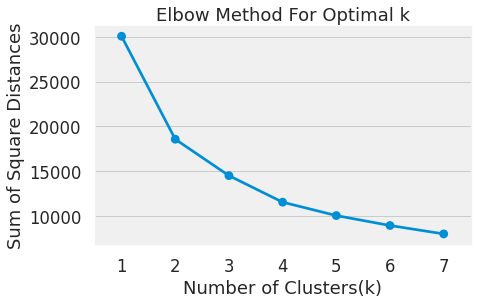

In [ ]:
X_features_rec_mon=df_merged[["Reach", "sociability", "Final_Sentiment"]]
scaler_rec_mon=preprocessing.StandardScaler()
X_rec_mon=scaler_rec_mon.fit_transform(X_features_rec_mon)
X = X_rec_mon
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,8):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 100)
    km = km.fit(X)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
print(df_merged.columns.tolist())

['author_id', 'Analysis', 'Final_Sentiment', 'Negative', 'Neutral', 'Polarity', 'Positive', 'REPEAT_TIME', 'Reach', 'Subjectivity', 'favorabilty', 'followee_followers_rt', 'followers_count', 'following_count', 'folws_stat_foloing_rt', 'like_count', 'likes_tweets_rt', 'listed_count', 'quote_count', 'reply_count', 'retweet_count', 'sociability', 'total_len', 'tweet_count']


In [ ]:
df2 = df_merged[df_merged.columns.difference(['created_at', 'created_at_dt', 'WeeklyPostingPeriod', 'cohort', 'REPEAT_USER_PROSPECTIVE', 'dayOfWeek', 'RootCohortGroup', 'REPEAT_USER', 'created_at_month'])]

In [ ]:
inertia_list = []
for n_clusters in range(1,21):
    model = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 0)
    model.fit(df_merged)
    inertia_list.append(model.inertia_)

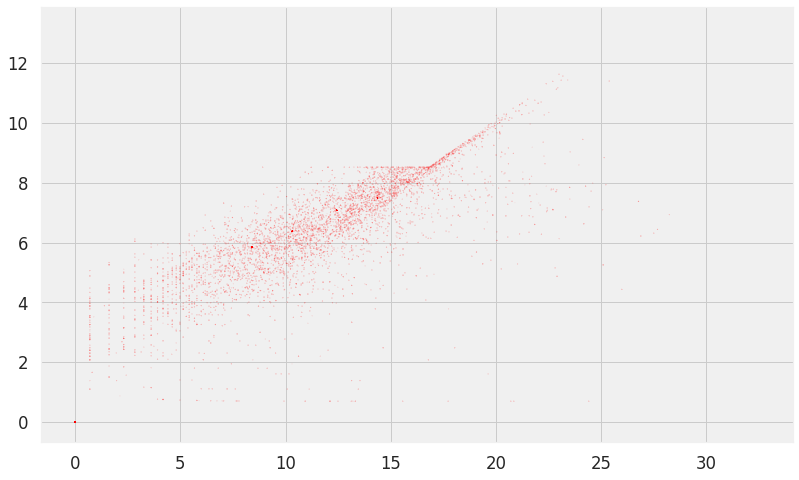

In [ ]:
fig = plt.figure(figsize = (12, 8))
plt.scatter( df_merged.Reach, df_merged.sociability, df_merged.Final_Sentiment, color = 'red')

<Figure size 864x576 with 0 Axes>

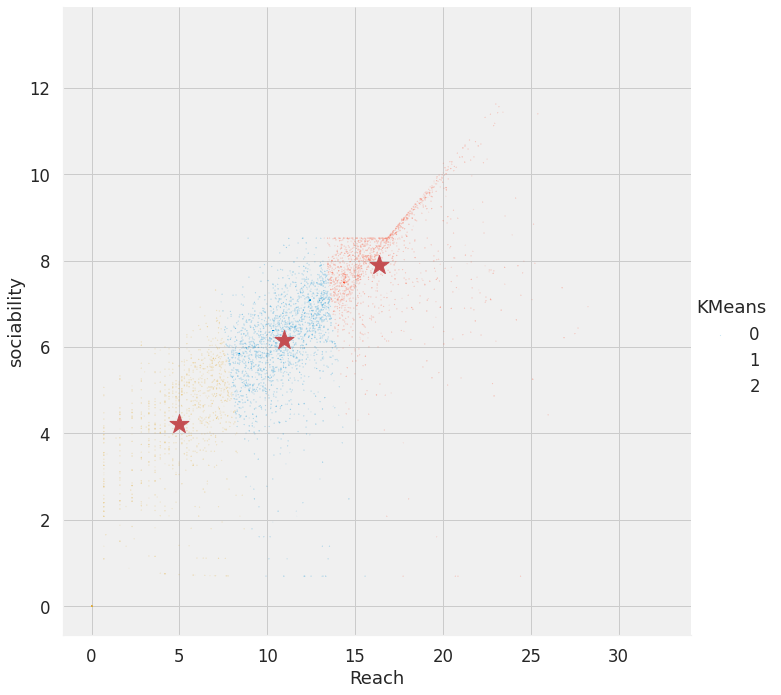

In [ ]:
fig = plt.figure(figsize = (12, 8))
my_data = np.column_stack((df_merged.Reach, df_merged.sociability, df_merged.Final_Sentiment))

km_model = KMeans(n_clusters = 3).fit(my_data)
my_clusters = km_model.cluster_centers_

# Put assigned labels to the original dataset..
df_merged['KMeans'] = km_model.labels_
p = sns.FacetGrid(data = df_merged, hue = 'KMeans', height = 10)
p.map(plt.scatter, 'Reach', 'sociability', 'Final_Sentiment')
p.add_legend()
plt.scatter(my_clusters[:, 0], my_clusters[:, 1], s = 400, marker = '*', c = 'r')

In [ ]:
km_model.cluster_centers_

array([[1.09305140e+01, 6.16393345e+00, 1.41085700e-03],
       [1.63630090e+01, 7.90204270e+00, 1.79302989e-03],
       [4.94810269e+00, 4.20928363e+00, 1.52538065e-03]])

In [ ]:
df_merged['KMeans'] = km_model.labels_
df_merged.groupby('KMeans').describe()

Analysis                                              Final_Sentiment  \
          count      mean       std  min  25%  50%  75%  max           count   
KMeans                                                                         
0        4391.0  1.179826  0.694366  0.0  1.0  1.0  2.0  2.0          4391.0   
1        3331.0  1.204880  0.676177  0.0  1.0  1.0  2.0  2.0          3331.0   
2        2298.0  1.165616  0.708834  0.0  1.0  1.0  2.0  2.0          2298.0   

                  ...   total_len        tweet_count                \
            mean  ...         75%    max       count          mean   
KMeans            ...                                                
0       0.001411  ...  219.000000  412.0      4391.0  16491.692991   
1       0.001790  ...  231.000000  855.0      3331.0  71771.810127   
2       0.001529  ...  222.685714  411.0      2298.0   2267.937073   

                                                                       
                  std    min      25%      50%         75%        max  
KMeans                                                                 
0        51373.002691    8.0   2934.0   7255.0  16661.4000  2729429.0  
1       126291.564844  169.0  14865.5  36223.0  84098.0000  2635315.0  
2         5449.552394    1.0    220.0    733.5   2208.4375   101017.0  

[3 rows x 184 columns]

In [ ]:
dt_kmeans = df_merged.copy()
dt_kmeans["author_id"] = df_merged["author_id"]
#dt_kmeans["Kmeans"] = km_model.labels_
dt_kmeans.head()

,author_id,Analysis,Final_Sentiment,Negative,Neutral,Polarity,Positive,REPEAT_TIME,Reach,Subjectivity,...,like_count,likes_tweets_rt,listed_count,quote_count,reply_count,retweet_count,sociability,total_len,tweet_count,KMeans
0,1.00018e+18,2.000000,0.010000,0.000000,0,0.062500,2.000000,1.0,14.382859,0.108333,...,0.000000,1.000056,4.0,0.000000,0.000000,0.000000,7.170889,294.000000,17778.0,1
1,1.00025e+18,0.142857,-0.001429,0.142857,0,-0.342857,0.000000,4.0,7.167809,0.514286,...,0.428571,1.434189,7.0,0.000000,0.285714,0.000000,5.707203,114.285714,178.0,2
2,1.00045e+18,1.000000,-0.013333,1.000000,0,0.000000,0.000000,2.0,2.302585,0.166667,...,0.000000,1.001647,0.0,0.000000,0.000000,0.000000,3.592736,118.000000,607.0,2
3,1.00074e+18,2.000000,0.010000,0.000000,0,0.221429,2.000000,7.5,8.687779,0.476786,...,0.500000,1.501724,0.0,0.000000,0.000000,0.250000,1.793922,162.500000,580.0,2
4,1.00125e+18,1.000000,0.003333,0.333333,0,-0.017130,0.666667,5.0,17.453287,0.269907,...,1.000000,2.000009,6.0,0.333333,0.333333,0.333333,8.760139,120.333333,111082.0,1


In [ ]:
'''

p = sns.FacetGrid(data = cluster_data, height = 10)
p.map(plt.scatter, 'Reach', 'sociability', 'favorabilty',)
p.add_legend()
plt.title('Data With Labels')
p = sns.FacetGrid(data = cluster_data, hue = 'KMeans', height = 10)
p.map(plt.scatter, 'Reach', 'sociability', 'favorabilty')
p.add_legend()
plt.title('K-Means Result')
'''


"\n\np = sns.FacetGrid(data = cluster_data, height = 10)\np.map(plt.scatter, 'Reach', 'sociability', 'favorabilty',)\np.add_legend()\nplt.title('Data With Labels')\np = sns.FacetGrid(data = cluster_data, hue = 'KMeans', height = 10)\np.map(plt.scatter, 'Reach', 'sociability', 'favorabilty')\np.add_legend()\nplt.title('K-Means Result')\n"

In [ ]:
dt_kmeans = df_merged.copy()

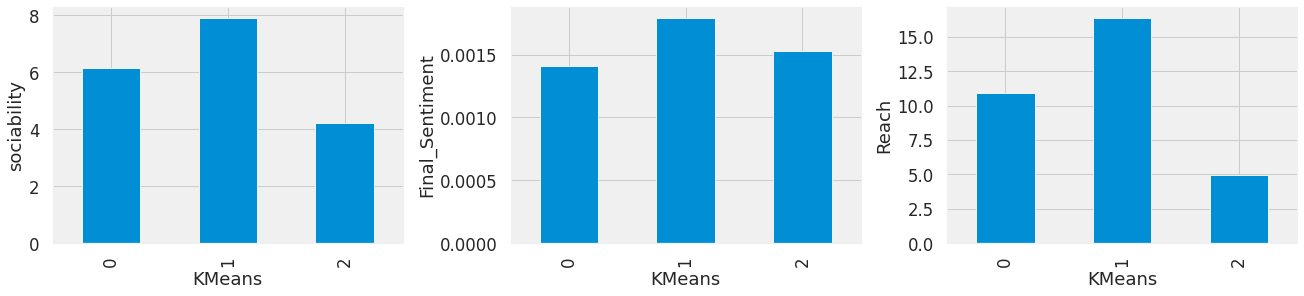

In [ ]:
cols = ["sociability", "Final_Sentiment", "Reach"]

fig, ax = plt.subplots(ncols=3, figsize=(18,4), constrained_layout=True)

dt_kmeans.groupby(['KMeans']).mean()["sociability"].T.plot(kind='bar', ax=ax[0], xlabel="KMeans", ylabel="sociability")
dt_kmeans.groupby(['KMeans']).mean()["Final_Sentiment"].T.plot(kind='bar', ax=ax[1], xlabel="KMeans", ylabel="Final_Sentiment")
dt_kmeans.groupby(['KMeans']).mean()["Reach"].T.plot(kind='bar', ax=ax[2], xlabel="KMeans", ylabel="Reach")
plt.show()

Based on sentiment can see that users in cluster 0 are most Reachd by sentiment. 



In [ ]:
dt_kmeans["KMeans"] = dt_kmeans["KMeans"].map({0: "users with high reach", 1: 'brokers of social movement', 2: 'identity keepers'})

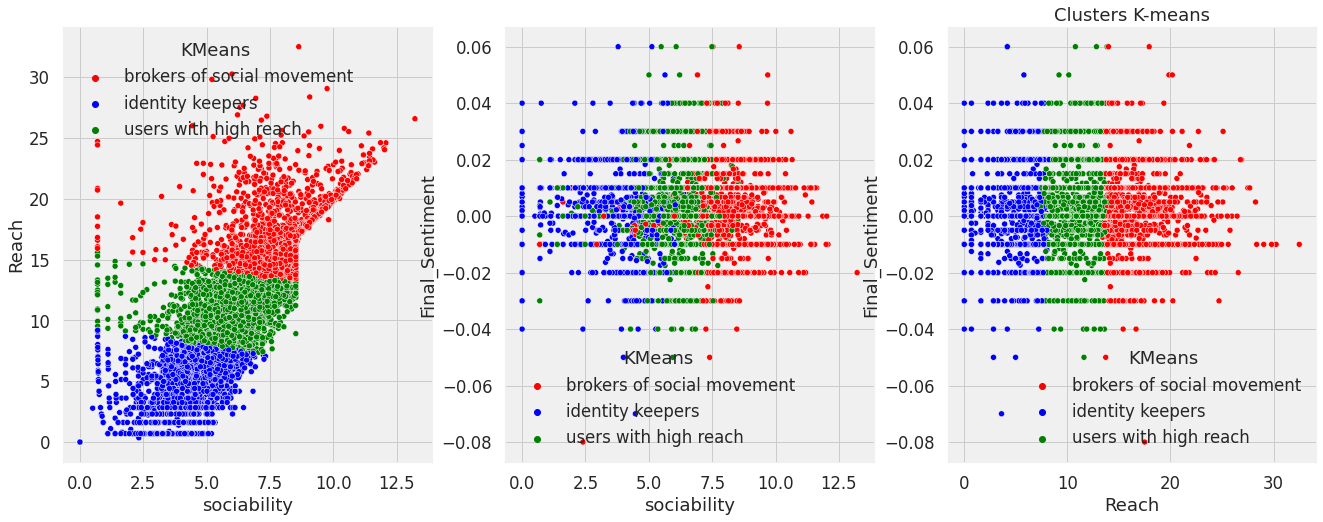

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,8))
sns.scatterplot(data=df_merged, x='sociability', y='Reach', hue=dt_kmeans["KMeans"], ax=ax[0], palette=["red", "blue", "green"])
sns.scatterplot(data=df_merged, x='sociability', y='Final_Sentiment', hue=dt_kmeans["KMeans"], ax=ax[1], palette=["red", "blue", "green"])
sns.scatterplot(data=df_merged, x='Reach', y='Final_Sentiment', hue=dt_kmeans["KMeans"], ax=ax[2], palette=["red", "blue", "green"])
plt.title("Clusters K-means")
plt.show()

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA().fit(X)
pca.n_components_, pca.explained_variance_ratio_

(3, array([0.60029706, 0.33335282, 0.06635012]))

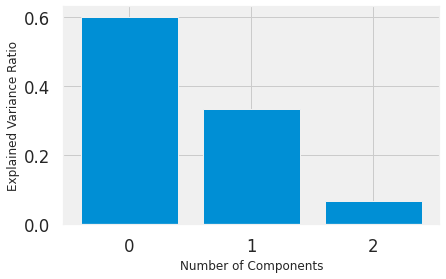

In [ ]:
# Plotting the variance of the components
features = range(pca.n_components_) 
plt.bar(features, pca.explained_variance_ratio_)
plt.xticks(features)
plt.xlabel('Number of Components',fontsize=12)
plt.ylabel('Explained Variance Ratio',fontsize=12)
plt.show()

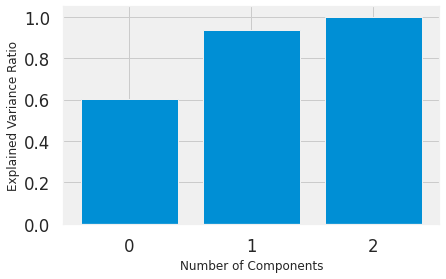

In [ ]:
#Plotting cumulative variance
features = range(pca.n_components_) 
plt.bar(features, pca.explained_variance_ratio_.cumsum())
plt.xticks(features)
plt.xlabel('Number of Components',fontsize=12)
plt.ylabel('Explained Variance Ratio',fontsize=12)
plt.show()

In [ ]:
#CALCULATING SCORES FOR ALL COMPONENTS
principalComponentes = pca.fit_transform(X) # Calculates scores for components

df_p = pd.DataFrame(principalComponentes)
df_p = pd.concat([df_p, df_merged[["author_id"]]], axis=1)
df_p.head()

,0,1,2,author_id
0,0.798981,-0.702185,0.103610,1.00018e+18
1,-0.863695,0.250788,-0.399463,1.00025e+18
2,-2.428140,1.238272,-0.293251,1.00045e+18
3,-2.167542,-0.721534,1.355886,1.00074e+18
4,1.883029,-0.141894,-0.052777,1.00125e+18


In [ ]:
#PCA WITH THE NUMBER OF COMPONENTS CHOSEN
pca = PCA(n_components=3)
principalComponentes = pca.fit_transform(X) # Calculates scores for components
df_pca = pd.DataFrame(principalComponentes, columns=['Component_1', 'Component_2', 'Component_3'])
df_pca.head()

,Component_1,Component_2,Component_3
0,0.798981,-0.702185,0.103610
1,-0.863695,0.250788,-0.399463
2,-2.428140,1.238272,-0.293251
3,-2.167542,-0.721534,1.355886
4,1.883029,-0.141894,-0.052777


We will incorporate the newly obtained PCA scores into the K-means algorithm. And so, we can perform segmentation based on the scores of the core components instead of the original features.

K-MEANS PCA

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

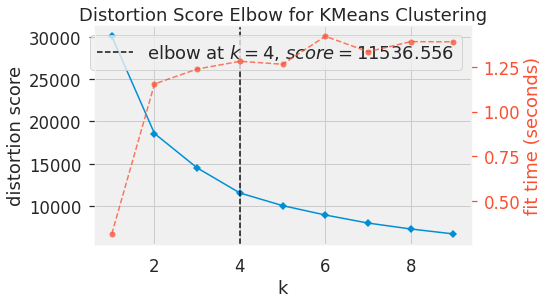

In [ ]:
visualizer = KElbowVisualizer(KMeans(init="k-means++", random_state=42), k=(1, 10))
visualizer.fit(df_pca.iloc[:,:3])        
visualizer.show() 

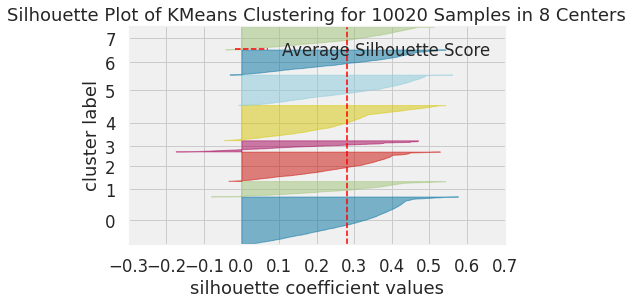

In [ ]:
visualizer = SilhouetteVisualizer(KMeans(init="k-means++", random_state=42), colors='yellowbrick')
visualizer.fit(df_pca.iloc[:,:3])        
visualizer.show() 

In [ ]:
kmeans = KMeans(n_clusters=3, init="k-means++", random_state=42)
kmeans_pca = kmeans.fit(df_pca.iloc[:,:3])

print("{} \n{} \n{} \n{}".format(kmeans_pca.n_clusters, kmeans_pca.cluster_centers_ , kmeans_pca.labels_, kmeans_pca.inertia_))

3 
[[ 0.64776083 -1.06994005 -0.00422475]
 [ 0.82747862  0.63932387  0.0195098 ]
 [-1.43523434  0.0830085  -0.01904126]] 
[0 2 2 ... 2 2 1] 
14501.58753355225


K-means with PCA obtained a lower inertia. Therefore, let's consider categorizing K-means countries with PCA.

In [ ]:
df_pca_kmeans = df_merged.copy()
df_pca_kmeans["author_id"] = df_merged["author_id"]
df_pca_kmeans["clusters_pca"] = kmeans_pca.labels_
df_pca_kmeans.head()

,author_id,Analysis,Final_Sentiment,Negative,Neutral,Polarity,Positive,REPEAT_TIME,Reach,Subjectivity,...,likes_tweets_rt,listed_count,quote_count,reply_count,retweet_count,sociability,total_len,tweet_count,KMeans,clusters_pca
0,1.00018e+18,2.000000,0.010000,0.000000,0,0.062500,2.000000,1.0,14.382859,0.108333,...,1.000056,4.0,0.000000,0.000000,0.000000,7.170889,294.000000,17778.0,1,0
1,1.00025e+18,0.142857,-0.001429,0.142857,0,-0.342857,0.000000,4.0,7.167809,0.514286,...,1.434189,7.0,0.000000,0.285714,0.000000,5.707203,114.285714,178.0,2,2
2,1.00045e+18,1.000000,-0.013333,1.000000,0,0.000000,0.000000,2.0,2.302585,0.166667,...,1.001647,0.0,0.000000,0.000000,0.000000,3.592736,118.000000,607.0,2,2
3,1.00074e+18,2.000000,0.010000,0.000000,0,0.221429,2.000000,7.5,8.687779,0.476786,...,1.501724,0.0,0.000000,0.000000,0.250000,1.793922,162.500000,580.0,2,2
4,1.00125e+18,1.000000,0.003333,0.333333,0,-0.017130,0.666667,5.0,17.453287,0.269907,...,2.000009,6.0,0.333333,0.333333,0.333333,8.760139,120.333333,111082.0,1,1


IDENTIFYING THE PRIORITY OF Feature IN EACH CLUSTER

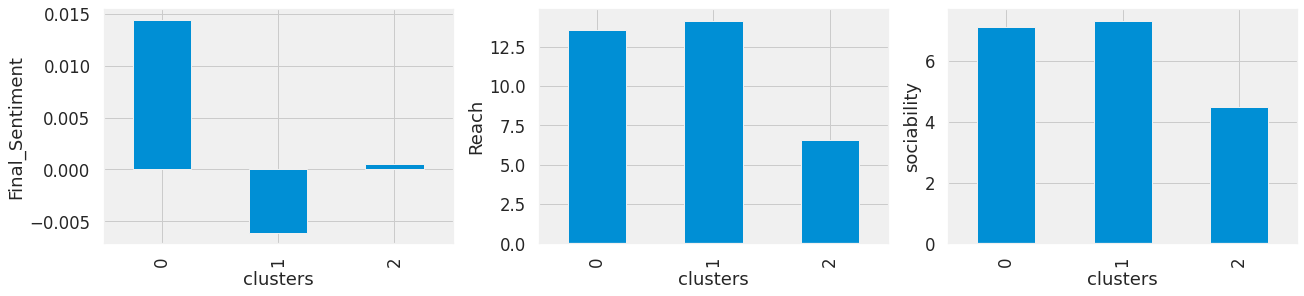

In [ ]:
cols = ["Final_Sentiment", "Reach", "sociability"]

fig, ax = plt.subplots(ncols=3, figsize=(18,4), constrained_layout=True)

df_pca_kmeans.groupby(['clusters_pca']).mean()["Final_Sentiment"].T.plot(kind='bar', ax=ax[0], xlabel="clusters", ylabel="Final_Sentiment")
df_pca_kmeans.groupby(['clusters_pca']).mean()["Reach"].T.plot(kind='bar', ax=ax[1], xlabel="clusters", ylabel="Reach")
df_pca_kmeans.groupby(['clusters_pca']).mean()["sociability"].T.plot(kind='bar', ax=ax[2], xlabel="clusters", ylabel="sociability")

plt.show()

PRIORITY OF USERS IN EACH CLUSTER

In [ ]:
df_pca_kmeans["clusters_labels"] = df_pca_kmeans["clusters_pca"].map({0: "Priority 3", 1:"Priority 1", 2:"Priority 2"}) 

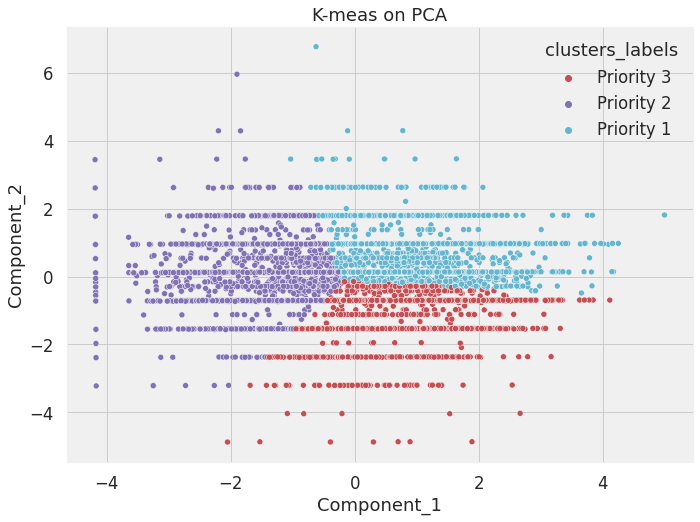

In [ ]:
#VIEW CLUSTERS BY PCA COMPONENTS

x_axis = df_pca["Component_1"]
y_axis = df_pca["Component_2"]
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis, y_axis, hue=df_pca_kmeans["clusters_labels"] , palette=['r', 'm', 'c'])
plt.title("K-meas on PCA")
plt.show()

Identity users in each group

In [ ]:
dt_kmeans[dt_kmeans['KMeans']=='users with high reach'][['author_id']]

,author_id
5,1.0015e+18
6,1.00167e+18
9,1.00198e+18
11,1.00239e+18
14,1.00262e+18
...,...
10007,98860702.0
10008,989990342.0
10009,990070195.0
10013,9927902.0


In [ ]:
dt_kmeans[dt_kmeans['KMeans']=='brokers of social movement'][['author_id']]

,author_id
0,1.00018e+18
4,1.00125e+18
8,1.00195e+18
12,1.00248e+18
17,1.00385e+18
...,...
10004,987961568.0
10010,99116591.0
10014,993269514.0
10016,993641287.0


In [ ]:
dt_kmeans[dt_kmeans['KMeans']=='identity keepers'][['author_id']]

,author_id
1,1.00025e+18
2,1.00045e+18
3,1.00074e+18
7,1.00183e+18
10,1.00225e+18
...,...
10002,987187854.0
10011,992061116.0
10012,992113345.0
10015,99352994.0


# User Specific Analysis

Users from the identity keepers cluster

In [ ]:
#let's take a look at some of those users 

user_col = dt_kmeans['author_id']

# we speciify a conditon 

selected_usr_cond = user_col =='1.00455e+18'

usr_cond = dt_kmeans[selected_usr_cond]

In [ ]:
usr_cond

,author_id,Analysis,Final_Sentiment,Negative,Neutral,Polarity,Positive,REPEAT_TIME,Reach,Subjectivity,...,like_count,likes_tweets_rt,listed_count,quote_count,reply_count,retweet_count,sociability,total_len,tweet_count,KMeans
20,1.00455e+18,0.0,0.0,0.0,0,-0.125,0.0,1.0,14.724022,0.375,...,0.0,1.000012,2.0,0.0,0.0,1.0,7.52564,130.0,83303.0,brokers of social movement


Users from the brokers of social movements groups

In [ ]:
#let's take a look at some of those users 

user_col = dt_kmeans['author_id']

# we speciify a conditon 

selected_usr_cond = user_col =='1.00045e+18'

usr_cond = dt_kmeans[selected_usr_cond]

In [ ]:
usr_cond

,author_id,Analysis,Final_Sentiment,Negative,Neutral,Polarity,Positive,REPEAT_TIME,Reach,Subjectivity,...,like_count,likes_tweets_rt,listed_count,quote_count,reply_count,retweet_count,sociability,total_len,tweet_count,KMeans
2,1.00045e+18,1.0,-0.013333,1.0,0,0.0,0.0,2.0,2.302585,0.166667,...,0.0,1.001647,0.0,0.0,0.0,0.0,3.592736,118.0,607.0,identity keepers


Users of high reach group

In [ ]:
#let's take a look at some of those users 

user_col = dt_kmeans['author_id']

# we speciify a conditon 

selected_usr_cond = user_col =='1.00167e+18'

usr_cond = dt_kmeans[selected_usr_cond]

In [ ]:
usr_cond

,author_id,Analysis,Final_Sentiment,Negative,Neutral,Polarity,Positive,REPEAT_TIME,Reach,Subjectivity,...,like_count,likes_tweets_rt,listed_count,quote_count,reply_count,retweet_count,sociability,total_len,tweet_count,KMeans
6,1.00167e+18,1.0,-0.015,1.0,0,0.0,0.0,1.5,13.538406,0.0,...,0.0,1.000043,4.0,0.0,0.5,0.0,6.836691,106.0,37874.0,users with high reach


# Additional Visualization of clusters

In [ ]:
km_model.labels_

array([1, 2, 2, ..., 0, 2, 1], dtype=int32)

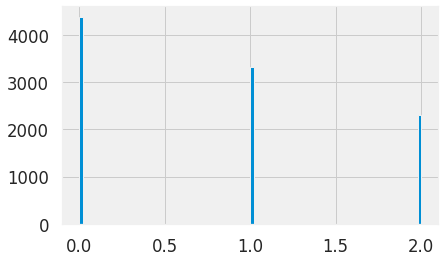

In [ ]:
pd.Series(km_model.labels_).hist(bins=100)

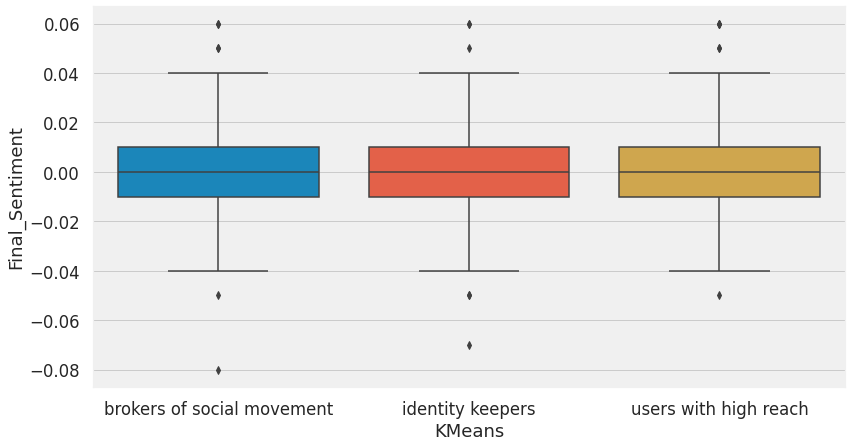

In [ ]:
plt.figure(figsize=(12,7))
sns.boxplot(x='KMeans',y='Final_Sentiment', data=dt_kmeans)

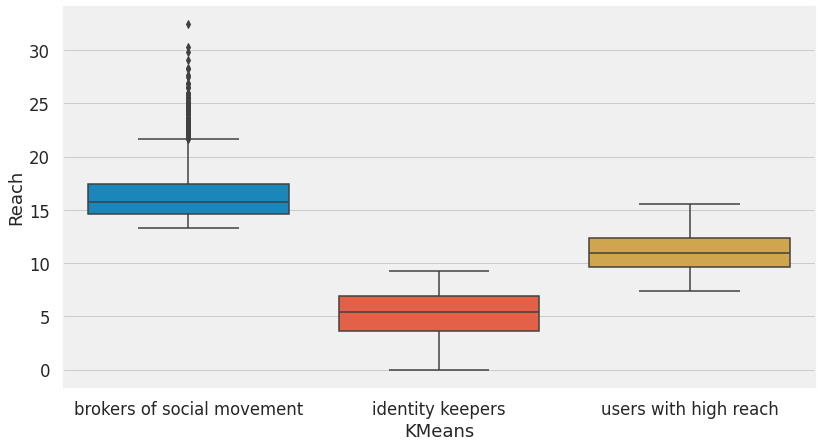

In [ ]:
plt.figure(figsize=(12,7))
sns.boxplot(x='KMeans',y='Reach', data=dt_kmeans)

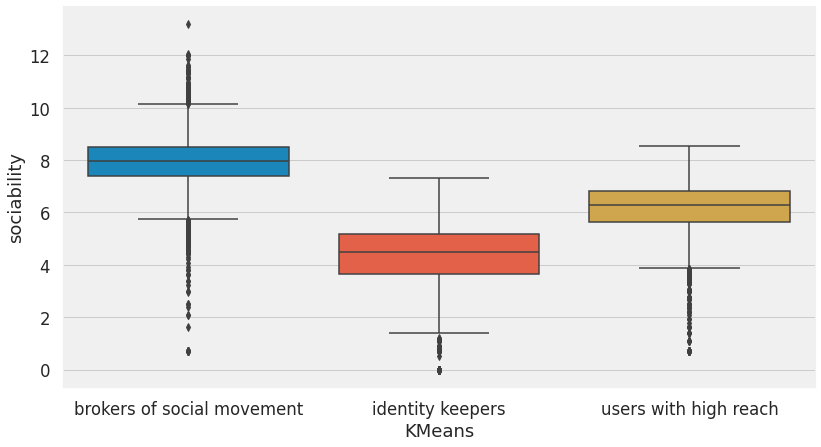

In [ ]:
plt.figure(figsize=(12,7))
sns.boxplot(x='KMeans',y='sociability', data=dt_kmeans)

In [ ]:
df_merged

,author_id,Analysis,Final_Sentiment,Negative,Neutral,Polarity,Positive,REPEAT_TIME,Reach,Subjectivity,...,like_count,likes_tweets_rt,listed_count,quote_count,reply_count,retweet_count,sociability,total_len,tweet_count,KMeans
0,1.00018e+18,2.000000,0.010000,0.000000,0,0.062500,2.000000,1.0,14.382859,0.108333,...,0.000000,1.000056,4.0,0.000000,0.000000,0.000000,7.170889,294.000000,17778.0,1
1,1.00025e+18,0.142857,-0.001429,0.142857,0,-0.342857,0.000000,4.0,7.167809,0.514286,...,0.428571,1.434189,7.0,0.000000,0.285714,0.000000,5.707203,114.285714,178.0,2
2,1.00045e+18,1.000000,-0.013333,1.000000,0,0.000000,0.000000,2.0,2.302585,0.166667,...,0.000000,1.001647,0.0,0.000000,0.000000,0.000000,3.592736,118.000000,607.0,2
3,1.00074e+18,2.000000,0.010000,0.000000,0,0.221429,2.000000,7.5,8.687779,0.476786,...,0.500000,1.501724,0.0,0.000000,0.000000,0.250000,1.793922,162.500000,580.0,2
4,1.00125e+18,1.000000,0.003333,0.333333,0,-0.017130,0.666667,5.0,17.453287,0.269907,...,1.000000,2.000009,6.0,0.333333,0.333333,0.333333,8.760139,120.333333,111082.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10015,99352994.0,0.500000,-0.005000,0.500000,0,-0.153472,0.000000,3.5,7.568896,0.199306,...,0.250000,1.251196,1.0,0.000000,0.250000,0.000000,5.869361,154.750000,836.0,2
10016,993641287.0,0.000000,0.000000,0.000000,0,-0.166667,0.000000,1.0,14.961985,0.633333,...,1.000000,2.000050,10.0,0.000000,0.000000,0.000000,8.296297,256.000000,19896.0,1
10017,99569050.0,1.000000,0.000000,1.000000,0,0.000000,0.000000,1.0,8.286521,0.000000,...,0.000000,1.000053,40.0,0.000000,0.000000,0.000000,5.587308,276.000000,19022.0,0
10018,99586080.0,0.000000,0.000000,0.000000,0,-0.415625,0.000000,1.0,0.000000,0.912500,...,0.000000,1.002882,0.0,0.000000,0.000000,0.000000,0.000000,278.000000,347.0,2


# Sentiment Polarity

In [ ]:
authors_clustered = df_merged.copy(deep=True)
authors_clustered.head()

,author_id,Analysis,Final_Sentiment,Negative,Neutral,Polarity,Positive,REPEAT_TIME,Reach,Subjectivity,...,like_count,likes_tweets_rt,listed_count,quote_count,reply_count,retweet_count,sociability,total_len,tweet_count,KMeans
0,1.00018e+18,2.000000,0.010000,0.000000,0,0.062500,2.000000,1.0,14.382859,0.108333,...,0.000000,1.000056,4.0,0.000000,0.000000,0.000000,7.170889,294.000000,17778.0,1
1,1.00025e+18,0.142857,-0.001429,0.142857,0,-0.342857,0.000000,4.0,7.167809,0.514286,...,0.428571,1.434189,7.0,0.000000,0.285714,0.000000,5.707203,114.285714,178.0,2
2,1.00045e+18,1.000000,-0.013333,1.000000,0,0.000000,0.000000,2.0,2.302585,0.166667,...,0.000000,1.001647,0.0,0.000000,0.000000,0.000000,3.592736,118.000000,607.0,2
3,1.00074e+18,2.000000,0.010000,0.000000,0,0.221429,2.000000,7.5,8.687779,0.476786,...,0.500000,1.501724,0.0,0.000000,0.000000,0.250000,1.793922,162.500000,580.0,2
4,1.00125e+18,1.000000,0.003333,0.333333,0,-0.017130,0.666667,5.0,17.453287,0.269907,...,1.000000,2.000009,6.0,0.333333,0.333333,0.333333,8.760139,120.333333,111082.0,1


In [ ]:
# conversion of sentiment into negative / positive / neutral based on the score
authors_clustered["Final_Sentiment"] = authors_clustered["Polarity"].apply(lambda x : "negative" if x < -0.5 else "positive" if x > 0.5 else "neutral")

# display the first 10 lines of the dataframe


authors_clustered[["author_id", "KMeans", "Polarity","Final_Sentiment", ]].head(10)

,author_id,KMeans,Polarity,Final_Sentiment
0,1.00018e+18,1,0.062500,neutral
1,1.00025e+18,2,-0.342857,neutral
2,1.00045e+18,2,0.000000,neutral
3,1.00074e+18,2,0.221429,neutral
4,1.00125e+18,1,-0.017130,neutral
5,1.0015e+18,0,0.000000,neutral
6,1.00167e+18,0,0.000000,neutral
7,1.00183e+18,2,0.062500,neutral
8,1.00195e+18,1,0.094667,neutral
9,1.00198e+18,0,0.200000,neutral


In [ ]:
polarity_intra_cluster = authors_clustered.groupby(["KMeans","Final_Sentiment"]).count()["author_id"].unstack(fill_value=0)

In [ ]:
polarity_intra_cluster.head()

Final_Sentiment,negative,neutral,positive
KMeans,,,
0,106,4067,218
1,74,3098,159
2,54,2107,137


Normalization

In [ ]:
polarity_intra_cluster["cluster_size"] = authors_clustered.groupby("KMeans").size() #Number of users for each cluster

In [ ]:
polarity_intra_cluster.head()

Final_Sentiment,negative,neutral,positive,cluster_size
KMeans,,,,
0,106,4067,218,4391
1,74,3098,159,3331
2,54,2107,137,2298


In [ ]:
polarity_intra_cluster["positive"] = polarity_intra_cluster["positive"] / polarity_intra_cluster["cluster_size"] *100
polarity_intra_cluster["neutral"] = polarity_intra_cluster["neutral"] / polarity_intra_cluster["cluster_size"] *100
polarity_intra_cluster["negative"] = polarity_intra_cluster["negative"] / polarity_intra_cluster["cluster_size"] *100

In [ ]:
polarity_intra_cluster = polarity_intra_cluster.round().astype("int")
polarity_intra_cluster.head()

Final_Sentiment,negative,neutral,positive,cluster_size
KMeans,,,,
0,2,93,5,4391
1,2,93,5,3331
2,2,92,6,2298


In [ ]:
# 8. Using the object-oriented interface method, plot the resample DataFrame using the df.plot() function. 

# Import the style from Matplotlib.
from matplotlib import style
# Use the graph style fivethirtyeight.
style.use('fivethirtyeight')

In [ ]:
# Plot a box-whisker chart
#import matplotlib.pyplot as plt
#polarity_intra_cluster['positive'].plot(kind='box', title='Positive Sentiment', figsize=(10,8))

#plt.show()

In [ ]:
# Plot a box-whisker chart
#import matplotlib.pyplot as plt
#polarity_intra_cluster['negative'].plot(kind='box', title='Negative Sentiment', figsize=(10,8))

#plt.show()

In [ ]:
'''
from seaborn import palettes
import seaborn as sb

plt.figure(figsize=(17,10))
sb.countplot(cluster_data['survivability'], hue=df2['KMeans'], palette = 'Set1')
plt.legend(loc='upper right')
plt.ylabel('Count', fontsize=15, fontweight='bold')
plt.xlabel('Number of Days', fontsize=15, fontweight='bold')
plt.title('Cluster Distribution With Respect To Survivability', fontsize=15, fontweight='bold')
plt.show()
'''

"\nfrom seaborn import palettes\nimport seaborn as sb\n\nplt.figure(figsize=(17,10))\nsb.countplot(cluster_data['survivability'], hue=df2['KMeans'], palette = 'Set1')\nplt.legend(loc='upper right')\nplt.ylabel('Count', fontsize=15, fontweight='bold')\nplt.xlabel('Number of Days', fontsize=15, fontweight='bold')\nplt.title('Cluster Distribution With Respect To Survivability', fontsize=15, fontweight='bold')\nplt.show()\n"

# Visaulization of Sentiment Distribution within Clusters

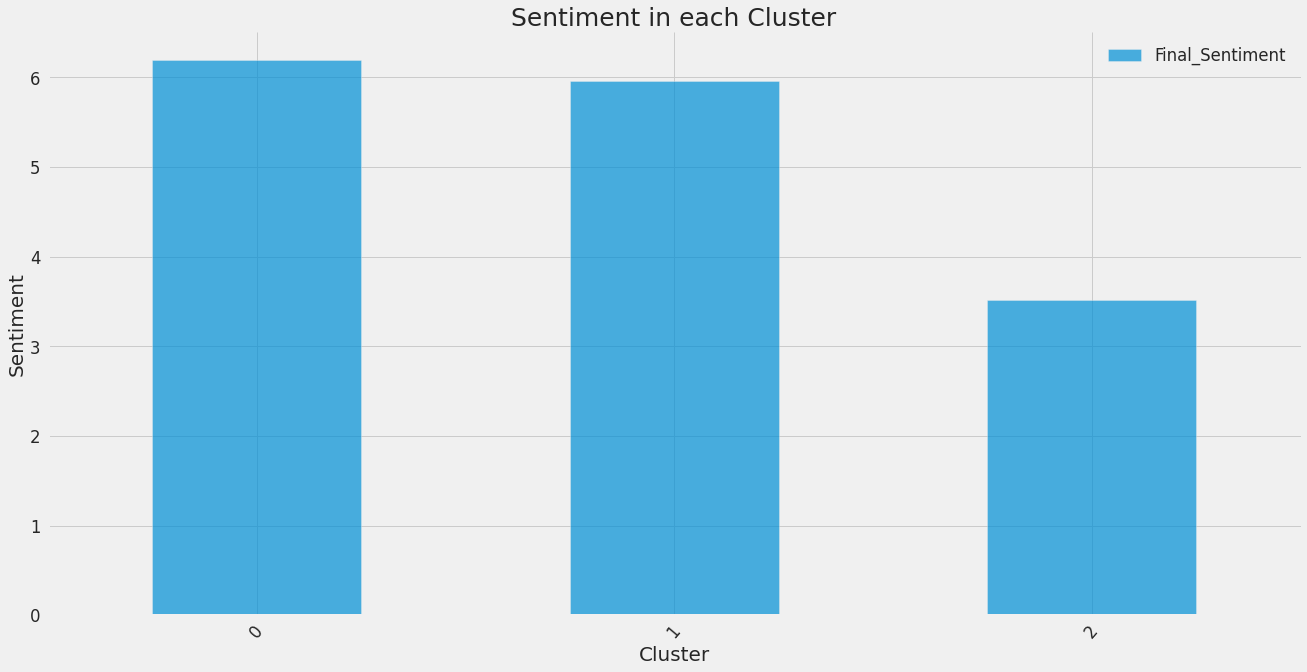

In [ ]:
newdata = df_merged[['Final_Sentiment','KMeans']].groupby(['KMeans']).sum().sort_values('Final_Sentiment',axis = 0,ascending = False)
fig, ax4 = plt.subplots(figsize=(20,10))
newdata.plot(kind = 'bar',alpha=0.7,ax=ax4)
plt.xticks(rotation = 50)
plt.title('Sentiment in each Cluster',fontsize = 25)
plt.xlabel('Cluster',fontsize = 20)
plt.ylabel('Sentiment',fontsize = 20)
top_side = ax4.spines["top"]
top_side.set_visible(False)
right_side = ax4.spines["right"]
right_side.set_visible(False)

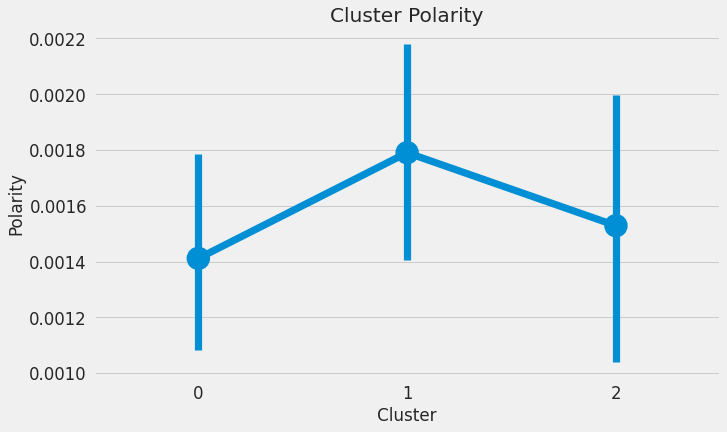

In [ ]:
plt.figure(figsize=(10, 6))
sns.pointplot(x = "KMeans", y = "Final_Sentiment", data = df_merged)
plt.xlabel("Cluster")
plt.ylabel("Polarity")
plt.title("Cluster Polarity")
plt.show()

In [ ]:
df_merged.to_csv('/content/toaggregate.csv')

# Feature Importance

**What are the factors associated with the change in user identity and can we predict them?**

In [ ]:
df_merged.head(2)

,author_id,Analysis,Final_Sentiment,Negative,Neutral,Polarity,Positive,REPEAT_TIME,Reach,Subjectivity,...,like_count,likes_tweets_rt,listed_count,quote_count,reply_count,retweet_count,sociability,total_len,tweet_count,KMeans
0,1.00018e+18,2.000000,0.010000,0.000000,0,0.062500,2.0,1.0,14.382859,0.108333,...,0.000000,1.000056,4.0,0.0,0.000000,0.0,7.170889,294.000000,17778.0,1
1,1.00025e+18,0.142857,-0.001429,0.142857,0,-0.342857,0.0,4.0,7.167809,0.514286,...,0.428571,1.434189,7.0,0.0,0.285714,0.0,5.707203,114.285714,178.0,2


In [ ]:
data = df_merged

In [ ]:
X = data[['sociability', 'Final_Sentiment', 'Reach']]
y = data['KMeans']

          sociability  Final_Sentiment      Reach
Variance     3.248656         0.000144  22.075631


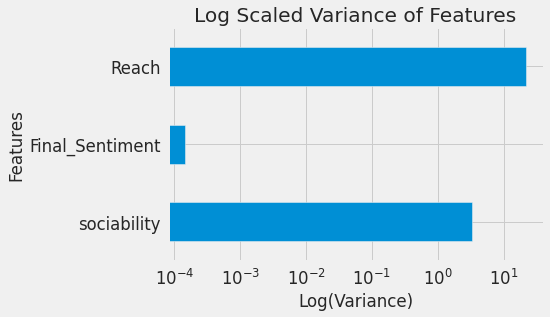

In [ ]:

# feature selection by variance
from sklearn.feature_selection import VarianceThreshold

# only works with numerical data, so we will change 'device' to numerical values
#X['device_num'] = X['device'].replace(['Smartphone', 'Tablet', 'Desktop'], [0, 1, 2])
#X = X.drop(columns='device')

# default drops features where variance is 0
sel = VarianceThreshold()
sel.fit_transform(X, y)

# features leftover after dropping
selected_features = X[X.columns[sel.get_support(indices=True)]].columns

# variances with features
variances = pd.Series(sel.variances_, X.columns)

df = pd.DataFrame(data=variances).T
df.index = ['Variance']
print(df)

variances.plot(kind='barh')
plt.xscale('log')
plt.xlabel('Log(Variance)')
plt.ylabel('Features')
plt.title('Log Scaled Variance of Features')
plt.show()

# 'Device' only has 5 categories, thus it's supposed to have a low variance
# 'Segments' and 'Hour' are numerical, so they have much more.
# There's decent variance across each feature in the data.

                          sociability  Final_Sentiment     Reach
Mutual Information Value     0.612296         0.005994  0.998825


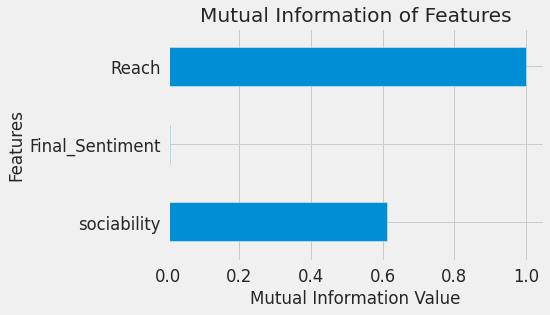

In [ ]:
# information gain by feature:
# can capture any kind of statistical dependency, but being nonparametric,
# they require more samples for accurate estimation
# Higher value means higher dependency
from sklearn.feature_selection import mutual_info_classif

importances = mutual_info_classif(X, y)
feat_importances = pd.Series(importances, X.columns)

df = pd.DataFrame(data=feat_importances).T
df.index = ['Mutual Information Value']
print(df)

feat_importances.plot(kind='barh')
plt.xlabel('Mutual Information Value')
plt.ylabel('Features')
plt.title('Mutual Information of Features')
plt.show()

# Since 'hour' has the highest value, it provides the most information for 'result'
# Followed by 'device'
# While 'segments' provides no information to 'result'

               sociability  Final_Sentiment         Reach
ANOVA F-Value   6727.64266         0.958822  20974.588457
P-value            0.00000         0.383380      0.000000


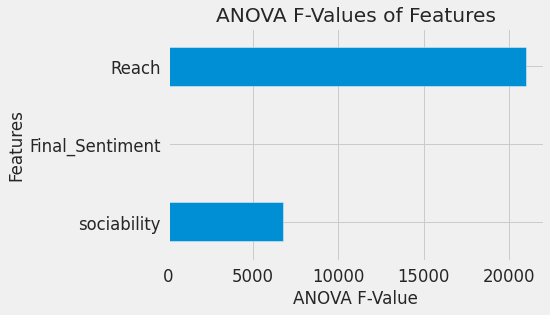

In [ ]:
# Feature selection based on ANOVA F-test:
# estimates the degree of linear dependency between two random variables.
# ANOVA F-value: variation between sample means/variation within the samples
from sklearn.feature_selection import f_classif

anova = f_classif(X, y)
f_vals = pd.Series(anova[0], X.columns)

df = pd.DataFrame(data = anova, columns = X.columns, index=['ANOVA F-Value', 'P-value'])
print(df)

f_vals.plot(kind='barh')
plt.xlabel('ANOVA F-Value')
plt.ylabel('Features')
plt.title('ANOVA F-Values of Features')
plt.show()

# With a confidence level of .05, only 'devices' p-value is < .05
# We can accept the null hypothesis: for 'device' is significant in explaining the variance
#   of the 'result'
# 'hour' is close to the alpha to accept the null. 
# 'segments' is far from the alpha, thus it is not significant in explaining 'result'


In [ ]:
estimator = SVC(kernel="linear")
selector = RFE(estimator)
selector = selector.fit(X, y)

df = pd.DataFrame(data=[selector.ranking_], columns = X.columns, index=['Ranking'])
df

# 'Device' is most important, followed by 'Segments', then 'Hour' 

,sociability,Final_Sentiment,Reach
Ranking,2,3,1


In [ ]:
# RFE + CV to find optimal features

from sklearn.feature_selection import RFECV

estimator = SVC(kernel="linear")
selector = RFECV(estimator, cv=5)
selector = selector.fit(X, y)

df = pd.DataFrame(data=[selector.ranking_], columns = X.columns, index=['Ranking'])
df

# Same results as above.
# We can use RFE with different models as well.

,sociability,Final_Sentiment,Reach
Ranking,1,2,1


# Applying Classification/Prediction Models

User behavior estimation using classification to predict user class/KMeans. Use algrms from previous notebook- temporal. Presentation follows  Zahra's paper. 

In [ ]:
dataset = data

In [ ]:
dataset

,author_id,Analysis,Final_Sentiment,Negative,Neutral,Polarity,Positive,REPEAT_TIME,Reach,Subjectivity,...,like_count,likes_tweets_rt,listed_count,quote_count,reply_count,retweet_count,sociability,total_len,tweet_count,KMeans
0,1.00018e+18,2.000000,0.010000,0.000000,0,0.062500,2.000000,1.0,14.382859,0.108333,...,0.000000,1.000056,4.0,0.000000,0.000000,0.000000,7.170889,294.000000,17778.0,1
1,1.00025e+18,0.142857,-0.001429,0.142857,0,-0.342857,0.000000,4.0,7.167809,0.514286,...,0.428571,1.434189,7.0,0.000000,0.285714,0.000000,5.707203,114.285714,178.0,2
2,1.00045e+18,1.000000,-0.013333,1.000000,0,0.000000,0.000000,2.0,2.302585,0.166667,...,0.000000,1.001647,0.0,0.000000,0.000000,0.000000,3.592736,118.000000,607.0,2
3,1.00074e+18,2.000000,0.010000,0.000000,0,0.221429,2.000000,7.5,8.687779,0.476786,...,0.500000,1.501724,0.0,0.000000,0.000000,0.250000,1.793922,162.500000,580.0,2
4,1.00125e+18,1.000000,0.003333,0.333333,0,-0.017130,0.666667,5.0,17.453287,0.269907,...,1.000000,2.000009,6.0,0.333333,0.333333,0.333333,8.760139,120.333333,111082.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10015,99352994.0,0.500000,-0.005000,0.500000,0,-0.153472,0.000000,3.5,7.568896,0.199306,...,0.250000,1.251196,1.0,0.000000,0.250000,0.000000,5.869361,154.750000,836.0,2
10016,993641287.0,0.000000,0.000000,0.000000,0,-0.166667,0.000000,1.0,14.961985,0.633333,...,1.000000,2.000050,10.0,0.000000,0.000000,0.000000,8.296297,256.000000,19896.0,1
10017,99569050.0,1.000000,0.000000,1.000000,0,0.000000,0.000000,1.0,8.286521,0.000000,...,0.000000,1.000053,40.0,0.000000,0.000000,0.000000,5.587308,276.000000,19022.0,0
10018,99586080.0,0.000000,0.000000,0.000000,0,-0.415625,0.000000,1.0,0.000000,0.912500,...,0.000000,1.002882,0.0,0.000000,0.000000,0.000000,0.000000,278.000000,347.0,2


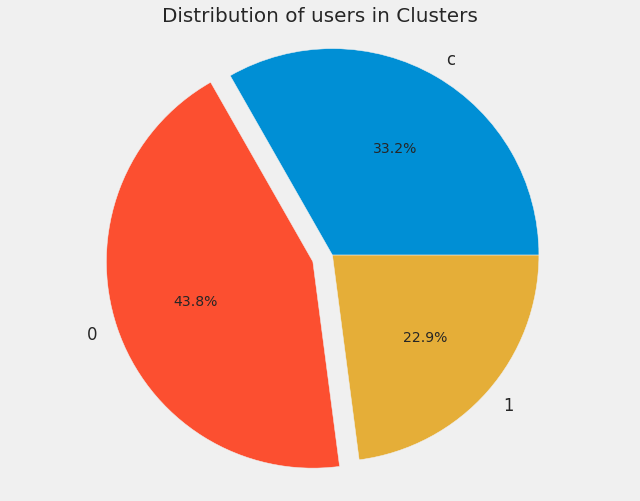

In [ ]:
labels = 'c', '0', '1'
sizes = [dataset.KMeans[dataset['KMeans']==1].count(), dataset.KMeans[dataset['KMeans']==0].count(), dataset.KMeans[dataset['KMeans']==2].count()]
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=(0, 0.1, 0), labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Distribution of users in Clusters", size = 20)
plt.show()

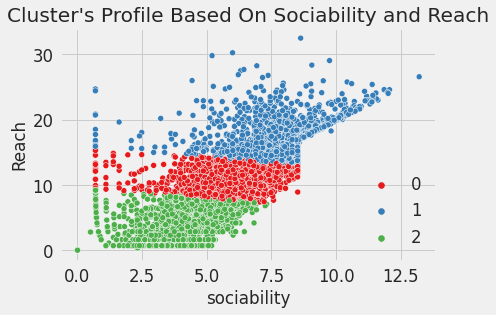

In [ ]:
pl = sns.scatterplot(data = dataset, x = dataset["sociability"], y = dataset["Reach"], hue = dataset["KMeans"], palette = 'Set1')
pl.set_title("Cluster's Profile Based On Sociability and Reach")
plt.legend()
plt.show()

In [ ]:

# takes too long to load

#plt.figure()
#pl=sns.swarmplot(x=dataset["KMeans"], y=dataset["sociability"], color= "#CBEDDD", alpha=0.5 )
#pl=sns.boxenplot(x=dataset["KMeans"], y=dataset["sociability"], palette='Set1')
#plt.show()

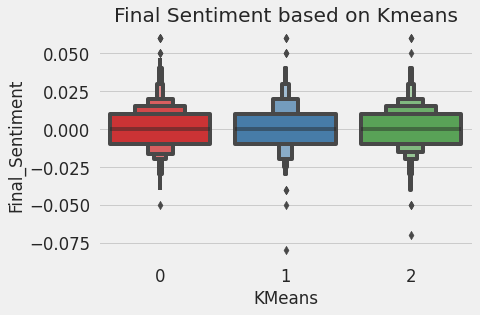

In [ ]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=dataset["Final_Sentiment"],x=dataset["KMeans"], palette= 'Set1')
pl.set_title("Final Sentiment based on Kmeans")
plt.show()

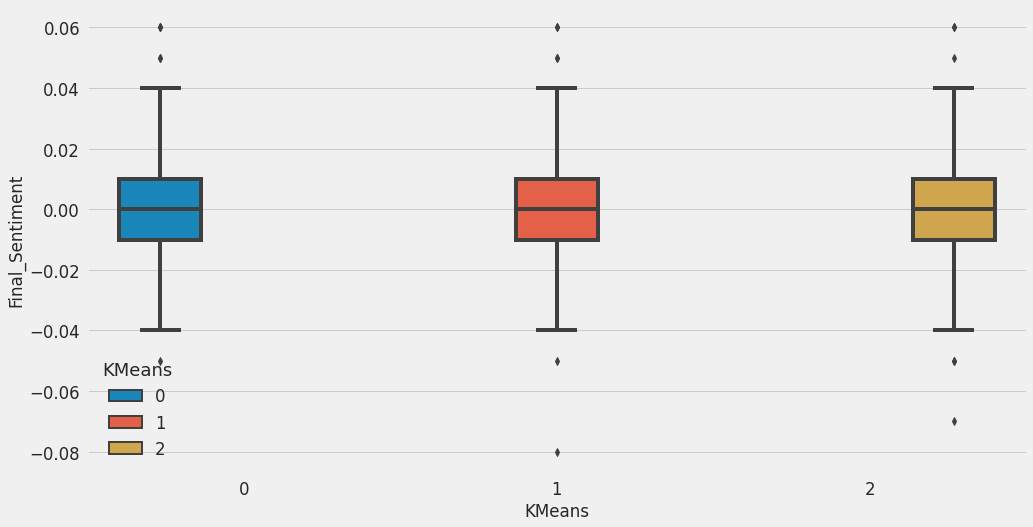

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(y='Final_Sentiment',x = 'KMeans', hue = 'KMeans',data = dataset)

In [ ]:
dataset = dataset[["sociability", "Final_Sentiment", "Reach", "KMeans"]]

In [ ]:
dataset

,sociability,Final_Sentiment,Reach,KMeans
0,7.170889,0.010000,14.382859,1
1,5.707203,-0.001429,7.167809,2
2,3.592736,-0.013333,2.302585,2
3,1.793922,0.010000,8.687779,2
4,8.760139,0.003333,17.453287,1
...,...,...,...,...
10015,5.869361,-0.005000,7.568896,2
10016,8.296297,0.000000,14.961985,1
10017,5.587308,0.000000,8.286521,0
10018,0.000000,0.000000,0.000000,2


In [ ]:
#Split into dependent and independent variables

In [ ]:
x = dataset[['sociability', 'Final_Sentiment', 'Reach']]
y = dataset['KMeans']


#x = dataset.iloc[:,0:3].values # the first 10 columns of the dataframe
#y = dataset.iloc[:,3].values  # the 10th column of the dataframe 

Normalize continuous variables using Standard Scaler

In [ ]:
sc = StandardScaler()
x = sc.fit_transform(x)

Split into train and test sets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(7014, 3)
(3006, 3)
(7014,)
(3006,)


Apply ML Algorithms

Logistic Regression

In [ ]:
lr=LogisticRegression()
lr.fit(x_train,y_train)
lr_ypred=lr.predict(x_test)
lr_acc = sklearn.metrics.accuracy_score(lr_ypred,y_test)
print("Logistic Regression Accuracy: ")
print(lr_acc*100,"%")

Logistic Regression Accuracy: 
99.56753160345974 %


Naive Bayes

In [ ]:
nb=GaussianNB()
nb.fit(x_train,y_train)
nb_ypred=nb.predict(x_test)
nb_acc = sklearn.metrics.accuracy_score(nb_ypred,y_test)
print("Naive Bayes Accuracy: ")
print(nb_acc*100,"%")

Naive Bayes Accuracy: 
95.9414504324684 %


Stochastic Gradient Descent

In [ ]:
sgd=SGDClassifier(loss='modified_huber',shuffle=True, random_state=15)
sgd.fit(x_train,y_train)
sgd_ypred=sgd.predict(x_test)
sgd_acc = sklearn.metrics.accuracy_score(sgd_ypred,y_test)
print("Stochastic Gradient Descent Accuracy: ")
print(sgd_acc*100,"%")

Stochastic Gradient Descent Accuracy: 
99.50099800399201 %


K-Nearest Neighbours


In [ ]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)
knn_ypred=knn.predict(x_test)
knn_acc = sklearn.metrics.accuracy_score(knn_ypred,y_test)
print("K-Nearest Neighbour Accuracy: ")
print(knn_acc*100,"%")

K-Nearest Neighbour Accuracy: 
98.20359281437125 %


Decision Tree

In [ ]:
dtree=DecisionTreeClassifier(max_depth=100,random_state=10,max_features=None, min_samples_leaf=100)
dtree.fit(x_train,y_train)
dtree_ypred=dtree.predict(x_test)
dtree_acc = sklearn.metrics.accuracy_score(dtree_ypred,y_test)
print("Decision Tree Accuracy: ")
print(dtree_acc*100,"%")

Decision Tree Accuracy: 
97.37192282102461 %


Random Forest

In [ ]:
rfm=RandomForestClassifier(n_estimators=200,oob_score=True,n_jobs=-1, random_state=20,max_features=None,min_samples_leaf=2)
rfm.fit(x_train,y_train)
rfm_ypred=rfm.predict(x_test)
rfm_acc = sklearn.metrics.accuracy_score(rfm_ypred,y_test)
print("Random Forest Accuracy: ")
print(rfm_acc*100,"%")

Random Forest Accuracy: 
99.43446440452428 %


Support Vector Machine

In [ ]:
svm=SVC(kernel="linear",C=0.025,random_state=None)
svm.fit(x_train,y_train)
svm_ypred=svm.predict(x_test)
svm_acc = sklearn.metrics.accuracy_score(svm_ypred,y_test)
print("Support Vector Machine Accuracy: ")
print(svm_acc*100,"%")

Support Vector Machine Accuracy: 
98.270126413839 %


ML Model Evaluation

Classification Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [ ]:
targetNames=['2', '0', '1']
print('For LR')
print(classification_report(y_test, lr_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For Naive Bayes')
print(classification_report(y_test, nb_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For SGD')
print(classification_report(y_test, sgd_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For KNN')
print(classification_report(y_test, knn_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For Decision Tree')
print(classification_report(y_test, dtree_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For Random Forest')
print(classification_report(y_test, rfm_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For SVM')
print(classification_report(y_test, svm_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')

For LR
              precision    recall  f1-score   support

           2       0.99      1.00      0.99      1285
           0       1.00      0.99      1.00      1012
           1       1.00      0.99      1.00       709

    accuracy                           1.00      3006
   macro avg       1.00      1.00      1.00      3006
weighted avg       1.00      1.00      1.00      3006

-----------------------------------------------------------------
For Naive Bayes
              precision    recall  f1-score   support

           2       0.96      0.95      0.95      1285
           0       0.96      0.98      0.97      1012
           1       0.96      0.96      0.96       709

    accuracy                           0.96      3006
   macro avg       0.96      0.96      0.96      3006
weighted avg       0.96      0.96      0.96      3006

-----------------------------------------------------------------
For SGD
              precision    recall  f1-score   support

           2       1

In [ ]:
unaggregated

,author_id,followers_count,following_count,listed_count,tweet_count,text,created_at,retweet_count,reply_count,like_count,...,favorabilty,Cleaning_Tweets,Subjectivity,Polarity,Analysis,Positive,Negative,Neutral,total_len,Final_Sentiment
9390,210858874.0,2191,1869,94,10525,"Lawmaker, former Kalamazoo policeman tweets #s...",2021-01-11,1,0,1,...,1.098644,"Lawmaker, former Kalamazoo policeman tweets st...",0.500000,-0.400000,0,0,0,0,115,0.00
9391,2251383210.0,3262,42,5,762093,Only one person showed up to the pro-Trump pro...,2021-01-11,0,0,0,...,0.693148,Only one person showed up to the pro-Trump pro...,0.525000,0.000000,1,0,1,0,133,-0.01
9392,1.28588e+18,8,114,0,301,"@BoycottHegemony Respectfully, I tend to be al...",2021-01-11,0,0,0,...,0.694807,"Respectfully, I tend to be aligned with most ...",0.473526,0.250050,2,2,0,0,221,0.01
9393,2251383210.0,3262,42,5,762093,Only one person showed up to the pro-Trump pro...,2021-01-11,0,0,0,...,0.693148,Only one person showed up to the pro-Trump pro...,0.525000,0.000000,1,0,1,0,133,-0.01
9394,7.51202e+17,46,1070,1,5264,That tells me conservative voices continue to ...,2021-01-11,0,0,0,...,0.693242,That tells me conservative voices continue to ...,0.325000,-0.050000,0,0,0,0,206,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31102,45693003.0,1467,2518,1,24544,If GOP doesn't step up and fix this #WeThePeop...,2021-01-05,2,0,2,...,1.386305,If GOP doesn't step up and fix this WeThePeopl...,0.477273,0.168182,2,2,0,0,154,0.01
31103,140298573.0,7,300,0,3678,@RepMeijer pls read &amp;share https://t.co/3c...,2021-01-05,0,0,0,...,0.693283,pls read &amp;share t.co/3cANfMp4IF 2019 Denn...,0.000000,0.000000,1,0,1,0,91,-0.01
31104,75191028.0,34,75,1,4411,Millions watching &amp; praying while the Hous...,2021-01-05,0,0,0,...,0.693261,Millions watching &amp; praying while the Hous...,1.000000,-0.800000,0,0,0,0,254,0.00
31105,4132841.0,52491,9708,2586,99166,This is today’s immoral GOP. \n\n#trump #gop #...,2021-01-05,0,0,1,...,1.098616,This is today’s immoral GOP. \n\ntrump gop mag...,0.000000,0.000000,1,0,1,0,135,-0.01


In [ ]:
df_pca_kmeans

,author_id,Analysis,Final_Sentiment,Negative,Neutral,Polarity,Positive,REPEAT_TIME,Reach,Subjectivity,...,listed_count,quote_count,reply_count,retweet_count,sociability,total_len,tweet_count,KMeans,clusters_pca,clusters_labels
0,1.00018e+18,2.000000,0.010000,0.000000,0,0.062500,2.000000,1.0,14.382859,0.108333,...,4.0,0.000000,0.000000,0.000000,7.170889,294.000000,17778.0,1,0,Priority 3
1,1.00025e+18,0.142857,-0.001429,0.142857,0,-0.342857,0.000000,4.0,7.167809,0.514286,...,7.0,0.000000,0.285714,0.000000,5.707203,114.285714,178.0,2,2,Priority 2
2,1.00045e+18,1.000000,-0.013333,1.000000,0,0.000000,0.000000,2.0,2.302585,0.166667,...,0.0,0.000000,0.000000,0.000000,3.592736,118.000000,607.0,2,2,Priority 2
3,1.00074e+18,2.000000,0.010000,0.000000,0,0.221429,2.000000,7.5,8.687779,0.476786,...,0.0,0.000000,0.000000,0.250000,1.793922,162.500000,580.0,2,2,Priority 2
4,1.00125e+18,1.000000,0.003333,0.333333,0,-0.017130,0.666667,5.0,17.453287,0.269907,...,6.0,0.333333,0.333333,0.333333,8.760139,120.333333,111082.0,1,1,Priority 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10015,99352994.0,0.500000,-0.005000,0.500000,0,-0.153472,0.000000,3.5,7.568896,0.199306,...,1.0,0.000000,0.250000,0.000000,5.869361,154.750000,836.0,2,2,Priority 2
10016,993641287.0,0.000000,0.000000,0.000000,0,-0.166667,0.000000,1.0,14.961985,0.633333,...,10.0,0.000000,0.000000,0.000000,8.296297,256.000000,19896.0,1,1,Priority 1
10017,99569050.0,1.000000,0.000000,1.000000,0,0.000000,0.000000,1.0,8.286521,0.000000,...,40.0,0.000000,0.000000,0.000000,5.587308,276.000000,19022.0,0,2,Priority 2
10018,99586080.0,0.000000,0.000000,0.000000,0,-0.415625,0.000000,1.0,0.000000,0.912500,...,0.0,0.000000,0.000000,0.000000,0.000000,278.000000,347.0,2,2,Priority 2


In [ ]:
final_df = pd.merge(unaggregated, df_pca_kmeans, on ='author_id')

In [ ]:
final_df

,author_id,followers_count_x,following_count_x,listed_count_x,tweet_count_x,text,created_at,retweet_count_x,reply_count_x,like_count_x,...,listed_count_y,quote_count_y,reply_count_y,retweet_count_y,sociability_y,total_len_y,tweet_count_y,KMeans,clusters_pca,clusters_labels
0,210858874.0,2191,1869,94,10525,"Lawmaker, former Kalamazoo policeman tweets #s...",2021-01-11,1,0,1,...,94.0,0.0,0.0,1.0,7.534229,115.0,10525.0,1,1,Priority 1
1,2251383210.0,3262,42,5,762093,Only one person showed up to the pro-Trump pro...,2021-01-11,0,0,0,...,5.0,0.0,0.0,0.0,3.784197,126.5,762093.0,1,1,Priority 1
2,2251383210.0,3262,42,5,762093,Only one person showed up to the pro-Trump pro...,2021-01-11,0,0,0,...,5.0,0.0,0.0,0.0,3.784197,126.5,762093.0,1,1,Priority 1
3,2251383210.0,3262,42,5,762093,Peloton is blocking the #StopTheSteal hashtag ...,2021-01-11,0,0,0,...,5.0,0.0,0.0,0.0,3.784197,126.5,762093.0,1,1,Priority 1
4,2251383210.0,3262,42,5,762093,Peloton is blocking the #StopTheSteal hashtag ...,2021-01-11,0,0,0,...,5.0,0.0,0.0,0.0,3.784197,126.5,762093.0,1,1,Priority 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21712,419251436.0,36,390,0,1356,"Dear @realDonaldTrump, No disrespect to the gr...",2021-01-05,0,0,0,...,0.0,0.0,0.0,0.0,5.971333,279.0,1356.0,2,2,Priority 2
21713,9.68168e+17,977,915,0,92601,"LIVE: President Trump in Dalton, GA #Georgia #...",2021-01-05,0,0,0,...,0.0,0.0,0.0,0.0,6.821109,101.0,92601.0,1,0,Priority 3
21714,33590667.0,5282,4450,83,127411,All hotels in DC are almost sold out. I'm driv...,2021-01-05,0,0,0,...,83.0,0.0,0.0,0.0,8.401109,128.0,127411.0,1,0,Priority 3
21715,452355595.0,3219,3098,0,36905,@HillaryClinton They thought they cheated enou...,2021-01-05,0,0,0,...,0.0,0.0,0.0,0.0,8.039157,195.0,36905.0,1,0,Priority 3


In [ ]:
#final_df.to_csv('/content/final_df_pre_event.csv')
#final_df.to_csv('/content/final_df_dur_event.csv')
final_df.to_csv('/content/final_df_post_event.csv')

In [ ]:
import pandas as pd
from functools import reduce

In [ ]:
data_frames = [unaggregated, df_pca_kmeans]

In [ ]:
df_merged_final = reduce(lambda  left,right: pd.merge(left,right,on=['author_id'],
                                            how='outer'), data_frames).fillna('void')
df_merged_final

,author_id,followers_count_x,following_count_x,listed_count_x,tweet_count_x,text,created_at,retweet_count_x,reply_count_x,like_count_x,...,listed_count_y,quote_count_y,reply_count_y,retweet_count_y,sociability_y,total_len_y,tweet_count_y,KMeans,clusters_pca,clusters_labels
0,210858874.0,2191,1869,94,10525,"Lawmaker, former Kalamazoo policeman tweets #s...",2021-01-11,1,0,1,...,94.0,0.0,0.0,1.0,7.534229,115.0,10525.0,1,1,Priority 1
1,2251383210.0,3262,42,5,762093,Only one person showed up to the pro-Trump pro...,2021-01-11,0,0,0,...,5.0,0.0,0.0,0.0,3.784197,126.5,762093.0,1,1,Priority 1
2,2251383210.0,3262,42,5,762093,Only one person showed up to the pro-Trump pro...,2021-01-11,0,0,0,...,5.0,0.0,0.0,0.0,3.784197,126.5,762093.0,1,1,Priority 1
3,2251383210.0,3262,42,5,762093,Peloton is blocking the #StopTheSteal hashtag ...,2021-01-11,0,0,0,...,5.0,0.0,0.0,0.0,3.784197,126.5,762093.0,1,1,Priority 1
4,2251383210.0,3262,42,5,762093,Peloton is blocking the #StopTheSteal hashtag ...,2021-01-11,0,0,0,...,5.0,0.0,0.0,0.0,3.784197,126.5,762093.0,1,1,Priority 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21712,419251436.0,36,390,0,1356,"Dear @realDonaldTrump, No disrespect to the gr...",2021-01-05,0,0,0,...,0.0,0.0,0.0,0.0,5.971333,279.0,1356.0,2,2,Priority 2
21713,9.68168e+17,977,915,0,92601,"LIVE: President Trump in Dalton, GA #Georgia #...",2021-01-05,0,0,0,...,0.0,0.0,0.0,0.0,6.821109,101.0,92601.0,1,0,Priority 3
21714,33590667.0,5282,4450,83,127411,All hotels in DC are almost sold out. I'm driv...,2021-01-05,0,0,0,...,83.0,0.0,0.0,0.0,8.401109,128.0,127411.0,1,0,Priority 3
21715,452355595.0,3219,3098,0,36905,@HillaryClinton They thought they cheated enou...,2021-01-05,0,0,0,...,0.0,0.0,0.0,0.0,8.039157,195.0,36905.0,1,0,Priority 3
